<p><br>
<center>
<b><h1>Analyzing and Predicting Crime Patterns in Boston: A Big Data Approach</h1></b>    
<b><h1>Northeastern University</h1></b>
<b><h1>Capstone Project</h1></b>
<b><h2></h2></b>
</center>
</p>

## Import Spark Session 

In [109]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from itertools import chain
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import col,isnan,when,count,create_map, lit
from sklearn.model_selection import train_test_split


from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.semi_supervised import LabelSpreading
from sklearn.svm import LinearSVC
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import f1_score


spark = SparkSession \
    .builder \
    .config("spark.ui.showConsoleProgress", "false") \
    .config("spark.sql.debug.maxToStringFields", 1000) \
    .appName("Boston Crime Analysis") \
    .getOrCreate()

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')


In [2]:
spark

## Read Dataset

In [3]:
crimes_df = spark.read.option("delimiter", ",").option("header", True).option("inferSchema", True).csv('merged_boston_crime_files.csv')
print(" The crimes dataframe has {} records".format(crimes_df.count()))

 The crimes dataframe has 739866 records


In [4]:
crimes_df.limit(10).toPandas() #Display head of data in pandas format

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I172040657,2629,Harassment,HARASSMENT,C11,397,None,6/15/15 0:00,2015,6,Monday,0,Part Two,MELBOURNE ST,42.291093,-71.065945,"(42.29109287, -71.06594539)"
1,I182061268,3201,Property Lost,PROPERTY - LOST,None,,None,6/15/15 0:00,2015,6,Monday,0,Part Three,BERNARD,NaN,NaN,None
2,I162013546,3201,Property Lost,PROPERTY - LOST,B3,433,None,6/15/15 0:00,2015,6,Monday,0,Part Three,NORFOLK ST,42.283634,-71.082813,"(42.28363434, -71.08281320)"
3,I152051083,3115,Investigate Person,INVESTIGATE PERSON,A7,20,None,6/15/15 0:00,2015,6,Monday,0,Part Three,PARIS ST,42.377023,-71.032247,"(42.37702319, -71.03224730)"
4,I152059178,2647,Other,THREATS TO DO BODILY HARM,C11,359,None,6/15/15 0:00,2015,6,Monday,0,Part Two,WASHINGTON ST,42.293606,-71.071887,"(42.29360585, -71.07188650)"
5,I152049897,3201,Property Lost,PROPERTY - LOST,B2,282,None,6/15/15 0:00,2015,6,Monday,0,Part Three,WASHINGTON ST,42.328663,-71.085634,"(42.32866284, -71.08563401)"
6,I152054279,1106,Confidence Games,FRAUD - CREDIT CARD / ATM FRAUD,B3,456,None,6/15/15 0:00,2015,6,Monday,0,Part Two,HARLEM ST,42.300217,-71.080979,"(42.30021684, -71.08097940)"
7,I152051083,3130,Search Warrants,SEARCH WARRANT,A7,20,None,6/15/15 0:00,2015,6,Monday,0,Part Three,PARIS ST,42.377023,-71.032247,"(42.37702319, -71.03224730)"
8,I152067251,1102,Fraud,FRAUD - FALSE PRETENSE / SCHEME,A1,93,None,6/15/15 0:00,2015,6,Monday,0,Part Two,FANEUIL HALL SQ,42.360205,-71.056208,"(42.36020464, -71.05620816)"
9,I152049588,614,Larceny From Motor Vehicle,LARCENY THEFT FROM MV - NON-ACCESSORY,D4,155,None,6/15/15 0:01,2015,6,Monday,0,Part One,CONCORD SQ,42.341384,-71.078989,"(42.34138415, -71.07898883)"


### Columns in the Dataset

In [5]:
crimes_df.columns

['INCIDENT_NUMBER',
 'OFFENSE_CODE',
 'OFFENSE_CODE_GROUP',
 'OFFENSE_DESCRIPTION',
 'DISTRICT',
 'REPORTING_AREA',
 'SHOOTING',
 'OCCURRED_ON_DATE',
 'YEAR',
 'MONTH',
 'DAY_OF_WEEK',
 'HOUR',
 'UCR_PART',
 'STREET',
 'Lat',
 'Long',
 'Location']

### DataTypes 

In [6]:
crimes_df.dtypes

[('INCIDENT_NUMBER', 'string'),
 ('OFFENSE_CODE', 'string'),
 ('OFFENSE_CODE_GROUP', 'string'),
 ('OFFENSE_DESCRIPTION', 'string'),
 ('DISTRICT', 'string'),
 ('REPORTING_AREA', 'string'),
 ('SHOOTING', 'string'),
 ('OCCURRED_ON_DATE', 'string'),
 ('YEAR', 'int'),
 ('MONTH', 'int'),
 ('DAY_OF_WEEK', 'string'),
 ('HOUR', 'int'),
 ('UCR_PART', 'string'),
 ('STREET', 'string'),
 ('Lat', 'double'),
 ('Long', 'double'),
 ('Location', 'string')]

In [7]:
crimes_df.printSchema()

root
 |-- INCIDENT_NUMBER: string (nullable = true)
 |-- OFFENSE_CODE: string (nullable = true)
 |-- OFFENSE_CODE_GROUP: string (nullable = true)
 |-- OFFENSE_DESCRIPTION: string (nullable = true)
 |-- DISTRICT: string (nullable = true)
 |-- REPORTING_AREA: string (nullable = true)
 |-- SHOOTING: string (nullable = true)
 |-- OCCURRED_ON_DATE: string (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- DAY_OF_WEEK: string (nullable = true)
 |-- HOUR: integer (nullable = true)
 |-- UCR_PART: string (nullable = true)
 |-- STREET: string (nullable = true)
 |-- Lat: double (nullable = true)
 |-- Long: double (nullable = true)
 |-- Location: string (nullable = true)



### Data Preprocessing 

In [8]:
## [Categorical and Numerical column] ##

# See how many categorical + numerical features:
cat_cols = [item[0] for item in crimes_df.dtypes if item[1].startswith('string')] 
num_cols = [item[0] for item in crimes_df.dtypes if item[1].startswith('int') | item[1].startswith('double')]

print(cat_cols)
print(str(len(cat_cols)) + '  categorical features')
print("-----------------------------------------------------------------------------------------")
print(num_cols)
print(str(len(num_cols)) + '  numerical features')

['INCIDENT_NUMBER', 'OFFENSE_CODE', 'OFFENSE_CODE_GROUP', 'OFFENSE_DESCRIPTION', 'DISTRICT', 'REPORTING_AREA', 'SHOOTING', 'OCCURRED_ON_DATE', 'DAY_OF_WEEK', 'UCR_PART', 'STREET', 'Location']
12  categorical features
-----------------------------------------------------------------------------------------
['YEAR', 'MONTH', 'HOUR', 'Lat', 'Long']
5  numerical features


### Find Duplicate Incidents

In [9]:
duplicate_rows = crimes_df.groupBy("INCIDENT_NUMBER").count().filter(col("count") > 1)
duplicate_rows.show(truncate = False)

+---------------+-----+
|INCIDENT_NUMBER|count|
+---------------+-----+
|I152049950     |2    |
|I152054634     |2    |
|I152058592     |2    |
|I152058778     |4    |
|I152064644     |2    |
|I152065640     |3    |
|I152071854     |2    |
|I152068167     |2    |
|I152073712     |2    |
|I152088634     |2    |
|I152093247     |2    |
|I152095697     |2    |
|I152060068     |2    |
|I152068574     |2    |
|I152087030     |2    |
|I152100388     |2    |
|I162002660     |2    |
|I162003710     |2    |
|I162003752     |2    |
|I162004555     |2    |
+---------------+-----+
only showing top 20 rows



In [10]:
# Drop duplicates based on selected columns
deduplicated_df = crimes_df.dropDuplicates(["INCIDENT_NUMBER"])

### Unique Values of Shooting Column

In [11]:
# Get unique values in a column
unique_values_shooting = deduplicated_df.select("SHOOTING").distinct()

# Show the unique values
unique_values_shooting.show()

+--------+
|SHOOTING|
+--------+
|       0|
|    null|
|       Y|
|       1|
+--------+



### Replace 0 or Null values with 'N' in Shooting Column

In [12]:
# Replace 0 or null values with 'N' in the 'value' column
deduplicated_df = deduplicated_df.withColumn("SHOOTING", when(col("SHOOTING").isNull() | (col("SHOOTING") == 0), "N").otherwise("Y"))

# Show the updated DataFrame
deduplicated_df.select("SHOOTING").distinct().show()

+--------+
|SHOOTING|
+--------+
|       Y|
|       N|
+--------+



### Year Distinct Values

In [13]:
# Get unique values in a column
unique_values_date = deduplicated_df.groupBy("YEAR").count()

# Show the unique values
unique_values_date.show()

+----+-----+
|YEAR|count|
+----+-----+
|2018|86734|
|2015|46966|
|2023|29295|
|2022|73852|
|null|  610|
|2019|87184|
|2020|70894|
|2016|87994|
|2017|89486|
|2021|71721|
+----+-----+



In [14]:
year_df = deduplicated_df.filter(col("YEAR").isNotNull())
year_df.limit(10).toPandas()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,020038446,1501,None,WEAPON VIOLATION - CARRY/ POSSESSING/ SALE/ TR...,B2,300,N,2020-06-03 01:15:00,2020,6,Wednesday,1,None,WASHINGTON ST,42.323808,-71.089150,"(42.3238077563779, -71.0891502345332)"
1,023844463,3115,None,INVESTIGATE PERSON,C6,,N,2021-10-16 01:16:00,2021,10,Saturday,1,None,G ST & E 8TH ST,NaN,NaN,None
2,102095489,3115,None,INVESTIGATE PERSON,E18,520,N,2019-11-25 16:30:00,2019,11,Monday,16,None,POYDRAS ST,42.256216,-71.124019,"(42.256215920402155, -71.12401947329023)"
3,120221042,3006,None,SICK/INJURED/MEDICAL - PERSON,E5,680,N,2021-04-02 10:45:00,2021,4,Friday,10,None,WASHINGTON ST,42.283902,-71.130863,"(42.283902436483125, -71.13086262643496)"
4,121055112,3201,None,PROPERTY - LOST/ MISSING,E13,574,N,2021-08-07 21:45:00,2021,8,Saturday,21,None,WASHINGTON ST,42.309719,-71.104294,"(42.30971856767274, -71.10429431787648)"
5,121090532,3005,None,SICK ASSIST,E18,,N,2021-12-11 06:30:00,2021,12,Saturday,6,None,GORDON AVE,NaN,NaN,None
6,122097815,3301,None,VERBAL DISPUTE,D4,617,N,2022-12-19 00:00:00,2022,12,Monday,0,None,HUNTINGTON AVENUE,NaN,NaN,None
7,172069979,3125,None,WARRANT ARREST,C6,175,N,2019-02-10 18:35:00,2019,2,Sunday,18,None,ATKINSON ST,42.332593,-71.068632,"(42.33259335, -71.06863173)"
8,172079908,3125,None,WARRANT ARREST,D4,138,N,2019-04-24 14:48:00,2019,4,Wednesday,14,None,NEWBURY ST,42.350597,-71.078810,"(42.35059705, -71.07881034)"
9,172092257,1800,None,Migrated Report - Drugs - Possession/Manufactu...,A1,,N,2019-09-27 11:10:00,2019,9,Friday,11,None,SOUTH ST,42.351102,-71.057352,"(42.35110202802516, -71.05735186002936)"


In [15]:
# Get unique values in a column
unique_values_date = year_df.groupBy("YEAR").count()

# Show the unique values
unique_values_date.show()

+----+-----+
|YEAR|count|
+----+-----+
|2018|86734|
|2015|46966|
|2023|29295|
|2022|73852|
|2019|87184|
|2020|70894|
|2016|87994|
|2017|89486|
|2021|71721|
+----+-----+



### Missing Value Treatment 

In [16]:
# Count null values in each column and display column name and count in a DataFrame
null_counts = year_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in year_df.columns])
null_counts_df = spark.createDataFrame(null_counts.collect(), null_counts.schema)

# Display the sorted DataFramer
null_counts_df.toPandas()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,0,0,332946,0,4198,0,0,0,0,0,0,0,333006,10158,62974,62974,62974


### Drop rows where the Offense Code  is not reported

In [17]:
deduplicated_df_without_nulls = year_df.filter(col("OFFENSE_CODE").isNotNull())

In [18]:
# Count null values in each column and display column name and count in a DataFrame
null_counts = deduplicated_df_without_nulls.select([sum(col(c).isNull().cast("int")).alias(c) for c in deduplicated_df_without_nulls.columns])
null_counts_df = spark.createDataFrame(null_counts.collect(), null_counts.schema)

# Display the sorted DataFramer
null_counts_df.toPandas()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,0,0,332946,0,4198,0,0,0,0,0,0,0,333006,10158,62974,62974,62974


### Drop rows with incorrect INCIDENT_NUMBERS

In [19]:
# Filter the column where the string starts with a double quotation mark
df = deduplicated_df_without_nulls.filter(~col("INCIDENT_NUMBER").startswith("\""))

# Show the resulting DataFrame
df.limit(10).toPandas()


,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,020038446,1501,None,WEAPON VIOLATION - CARRY/ POSSESSING/ SALE/ TR...,B2,300,N,2020-06-03 01:15:00,2020,6,Wednesday,1,None,WASHINGTON ST,42.323808,-71.089150,"(42.3238077563779, -71.0891502345332)"
1,023844463,3115,None,INVESTIGATE PERSON,C6,,N,2021-10-16 01:16:00,2021,10,Saturday,1,None,G ST & E 8TH ST,NaN,NaN,None
2,102095489,3115,None,INVESTIGATE PERSON,E18,520,N,2019-11-25 16:30:00,2019,11,Monday,16,None,POYDRAS ST,42.256216,-71.124019,"(42.256215920402155, -71.12401947329023)"
3,120221042,3006,None,SICK/INJURED/MEDICAL - PERSON,E5,680,N,2021-04-02 10:45:00,2021,4,Friday,10,None,WASHINGTON ST,42.283902,-71.130863,"(42.283902436483125, -71.13086262643496)"
4,121055112,3201,None,PROPERTY - LOST/ MISSING,E13,574,N,2021-08-07 21:45:00,2021,8,Saturday,21,None,WASHINGTON ST,42.309719,-71.104294,"(42.30971856767274, -71.10429431787648)"
5,121090532,3005,None,SICK ASSIST,E18,,N,2021-12-11 06:30:00,2021,12,Saturday,6,None,GORDON AVE,NaN,NaN,None
6,122097815,3301,None,VERBAL DISPUTE,D4,617,N,2022-12-19 00:00:00,2022,12,Monday,0,None,HUNTINGTON AVENUE,NaN,NaN,None
7,172069979,3125,None,WARRANT ARREST,C6,175,N,2019-02-10 18:35:00,2019,2,Sunday,18,None,ATKINSON ST,42.332593,-71.068632,"(42.33259335, -71.06863173)"
8,172079908,3125,None,WARRANT ARREST,D4,138,N,2019-04-24 14:48:00,2019,4,Wednesday,14,None,NEWBURY ST,42.350597,-71.078810,"(42.35059705, -71.07881034)"
9,172092257,1800,None,Migrated Report - Drugs - Possession/Manufactu...,A1,,N,2019-09-27 11:10:00,2019,9,Friday,11,None,SOUTH ST,42.351102,-71.057352,"(42.35110202802516, -71.05735186002936)"


In [20]:
# Count null values in each column and display column name and count in a DataFrame
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts_df = spark.createDataFrame(null_counts.collect(), null_counts.schema)

# Display the sorted DataFramer
null_counts_df.toPandas()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,0,0,332946,0,4198,0,0,0,0,0,0,0,333006,10158,62974,62974,62974


### Handle Missing Offence Group Code 

In [21]:
# Group by OFFENSE_CODE and collect OFFENSE_CODE_GROUP values as list
grouped_df = df.groupBy("OFFENSE_CODE").agg(collect_list("OFFENSE_CODE_GROUP").alias("OFFENSE_CODE_GROUP"))

# Collect the code mapping as a dictionary
code_mapping = grouped_df.rdd.collectAsMap()

# Iterate over dictionary and select first element from each list
for key in code_mapping:
    code_mapping[key] = code_mapping[key][0] if code_mapping[key] else None

In [22]:
# UDF to map code values to group values
code_to_group_udf = udf(lambda code: code_mapping.get(code, None), StringType())

# Fill missing values in OFFENSE_CODE_GROUP based on OFFENSE_CODE
df_filled = df.withColumn(
    "OFFENSE_CODE_GROUP",
    when(col("OFFENSE_CODE_GROUP").isNull(), code_to_group_udf(col("OFFENSE_CODE"))).otherwise(col("OFFENSE_CODE_GROUP"))
)

# Show the resulting DataFrame
df_filled.limit(10).toPandas()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,020038446,1501,Firearm Violations,WEAPON VIOLATION - CARRY/ POSSESSING/ SALE/ TR...,B2,300,N,2020-06-03 01:15:00,2020,6,Wednesday,1,None,WASHINGTON ST,42.323808,-71.089150,"(42.3238077563779, -71.0891502345332)"
1,023844463,3115,Investigate Person,INVESTIGATE PERSON,C6,,N,2021-10-16 01:16:00,2021,10,Saturday,1,None,G ST & E 8TH ST,NaN,NaN,None
2,102095489,3115,Investigate Person,INVESTIGATE PERSON,E18,520,N,2019-11-25 16:30:00,2019,11,Monday,16,None,POYDRAS ST,42.256216,-71.124019,"(42.256215920402155, -71.12401947329023)"
3,120221042,3006,Medical Assistance,SICK/INJURED/MEDICAL - PERSON,E5,680,N,2021-04-02 10:45:00,2021,4,Friday,10,None,WASHINGTON ST,42.283902,-71.130863,"(42.283902436483125, -71.13086262643496)"
4,121055112,3201,Property Lost,PROPERTY - LOST/ MISSING,E13,574,N,2021-08-07 21:45:00,2021,8,Saturday,21,None,WASHINGTON ST,42.309719,-71.104294,"(42.30971856767274, -71.10429431787648)"
5,121090532,3005,None,SICK ASSIST,E18,,N,2021-12-11 06:30:00,2021,12,Saturday,6,None,GORDON AVE,NaN,NaN,None
6,122097815,3301,Verbal Disputes,VERBAL DISPUTE,D4,617,N,2022-12-19 00:00:00,2022,12,Monday,0,None,HUNTINGTON AVENUE,NaN,NaN,None
7,172069979,3125,Warrant Arrests,WARRANT ARREST,C6,175,N,2019-02-10 18:35:00,2019,2,Sunday,18,None,ATKINSON ST,42.332593,-71.068632,"(42.33259335, -71.06863173)"
8,172079908,3125,Warrant Arrests,WARRANT ARREST,D4,138,N,2019-04-24 14:48:00,2019,4,Wednesday,14,None,NEWBURY ST,42.350597,-71.078810,"(42.35059705, -71.07881034)"
9,172092257,1800,None,Migrated Report - Drugs - Possession/Manufactu...,A1,,N,2019-09-27 11:10:00,2019,9,Friday,11,None,SOUTH ST,42.351102,-71.057352,"(42.35110202802516, -71.05735186002936)"


In [23]:
# Count null values in each column and display column name and count in a DataFrame
null_counts = df_filled.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_filled.columns])
null_counts_df = spark.createDataFrame(null_counts.collect(), null_counts.schema)

# Display the sorted DataFramer
null_counts_df.toPandas()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,0,0,12455,0,4198,0,0,0,0,0,0,0,333006,10158,62974,62974,62974


### Handle Missing UCR Code

In [24]:
OFFENSE_CODE_GROUP_NULL = df_filled.filter(col("UCR_PART").isNull())


In [25]:
grouped_df_ucr = df_filled.groupBy("OFFENSE_CODE").agg(collect_list("UCR_PART").alias("UCR_PART"))

# Collect the code mapping as a dictionary
code_mapping_ucr = grouped_df_ucr.rdd.collectAsMap()

# Iterate over dictionary and select first element from each list
for key in code_mapping_ucr:
    code_mapping_ucr[key] = code_mapping_ucr[key][0] if code_mapping_ucr[key] else None

In [26]:
# UDF to map code values to group values
code_to_group_ucr = udf(lambda code: code_mapping_ucr.get(code, None), StringType())

# Fill missing values in OFFENSE_CODE_GROUP based on OFFENSE_CODE
df_filled_ucr = df_filled.withColumn(
    "UCR_PART",
    when(col("UCR_PART").isNull(), code_to_group_ucr(col("OFFENSE_CODE"))).otherwise(col("UCR_PART"))
)

# Show the resulting DataFrame`
df_filled_ucr.limit(10).toPandas()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,020038446,1501,Firearm Violations,WEAPON VIOLATION - CARRY/ POSSESSING/ SALE/ TR...,B2,300,N,2020-06-03 01:15:00,2020,6,Wednesday,1,Part Two,WASHINGTON ST,42.323808,-71.089150,"(42.3238077563779, -71.0891502345332)"
1,023844463,3115,Investigate Person,INVESTIGATE PERSON,C6,,N,2021-10-16 01:16:00,2021,10,Saturday,1,Part Three,G ST & E 8TH ST,NaN,NaN,None
2,102095489,3115,Investigate Person,INVESTIGATE PERSON,E18,520,N,2019-11-25 16:30:00,2019,11,Monday,16,Part Three,POYDRAS ST,42.256216,-71.124019,"(42.256215920402155, -71.12401947329023)"
3,120221042,3006,Medical Assistance,SICK/INJURED/MEDICAL - PERSON,E5,680,N,2021-04-02 10:45:00,2021,4,Friday,10,Part Three,WASHINGTON ST,42.283902,-71.130863,"(42.283902436483125, -71.13086262643496)"
4,121055112,3201,Property Lost,PROPERTY - LOST/ MISSING,E13,574,N,2021-08-07 21:45:00,2021,8,Saturday,21,Part Three,WASHINGTON ST,42.309719,-71.104294,"(42.30971856767274, -71.10429431787648)"
5,121090532,3005,None,SICK ASSIST,E18,,N,2021-12-11 06:30:00,2021,12,Saturday,6,None,GORDON AVE,NaN,NaN,None
6,122097815,3301,Verbal Disputes,VERBAL DISPUTE,D4,617,N,2022-12-19 00:00:00,2022,12,Monday,0,Part Three,HUNTINGTON AVENUE,NaN,NaN,None
7,172069979,3125,Warrant Arrests,WARRANT ARREST,C6,175,N,2019-02-10 18:35:00,2019,2,Sunday,18,Part Three,ATKINSON ST,42.332593,-71.068632,"(42.33259335, -71.06863173)"
8,172079908,3125,Warrant Arrests,WARRANT ARREST,D4,138,N,2019-04-24 14:48:00,2019,4,Wednesday,14,Part Three,NEWBURY ST,42.350597,-71.078810,"(42.35059705, -71.07881034)"
9,172092257,1800,None,Migrated Report - Drugs - Possession/Manufactu...,A1,,N,2019-09-27 11:10:00,2019,9,Friday,11,None,SOUTH ST,42.351102,-71.057352,"(42.35110202802516, -71.05735186002936)"


In [27]:
# Count null values in each column and display column name and count in a DataFrame
null_counts = df_filled_ucr.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_filled_ucr.columns])
null_counts_df = spark.createDataFrame(null_counts.collect(), null_counts.schema)

# Display the sorted DataFramer
null_counts_df.toPandas()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,0,0,12455,0,4198,0,0,0,0,0,0,0,12517,10158,62974,62974,62974


### Explore Null values in Lat and Long 

In [28]:
Lat_NULL = df_filled.filter(col("Lat").isNull())
Lat_NULL.toPandas()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,023844463,3115,Investigate Person,INVESTIGATE PERSON,C6,,N,2021-10-16 01:16:00,2021,10,Saturday,1,None,G ST & E 8TH ST,NaN,NaN,None
1,121090532,3005,None,SICK ASSIST,E18,,N,2021-12-11 06:30:00,2021,12,Saturday,6,None,GORDON AVE,NaN,NaN,None
2,122097815,3301,Verbal Disputes,VERBAL DISPUTE,D4,617,N,2022-12-19 00:00:00,2022,12,Monday,0,None,HUNTINGTON AVENUE,NaN,NaN,None
3,182024587,3125,Warrant Arrests,WARRANT ARREST,A1,101,N,2019-02-15 02:30:00,2019,2,Friday,2,None,COMMERCIAL ST,NaN,NaN,None
4,182051106,3125,Warrant Arrests,WARRANT ARREST - BOSTON WARRANT (MUST BE SUPPL...,B3,465,N,2020-11-22 00:00:00,2020,11,Sunday,0,None,BLUE HILL AVE,NaN,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62969,I182093166,1402,Vandalism,VANDALISM,D4,,N,2018-11-10 21:35:00,2018,11,Saturday,21,Part Two,BERKELEY ST,NaN,NaN,None
62970,I182094024,802,Simple Assault,ASSAULT SIMPLE - BATTERY,A1,77,N,2018-11-20 20:10:00,2018,11,Tuesday,20,Part Two,BOWKER ST,NaN,NaN,None
62971,I182096616,1402,Vandalism,VANDALISM,None,,N,2018-11-30 15:20:00,2018,11,Friday,15,Part Two,RADCLIFFE,NaN,NaN,None
62972,I182101580,3831,Motor Vehicle Accident Response,M/V - LEAVING SCENE - PROPERTY DAMAGE,A1,,N,2018-12-17 15:41:00,2018,12,Monday,15,Part Three,ARCH ST,NaN,NaN,None


### Add Month Name Column 

In [29]:
# Change 'year' and 'month' columns to strings
df_with_strings = df_filled_ucr.withColumn("YEAR", col("YEAR").cast("string")) \
                    .withColumn("MONTH", col("MONTH").cast("string"))

# Show the DataFrame with string columns
df_with_strings.dtypes

[('INCIDENT_NUMBER', 'string'),
 ('OFFENSE_CODE', 'string'),
 ('OFFENSE_CODE_GROUP', 'string'),
 ('OFFENSE_DESCRIPTION', 'string'),
 ('DISTRICT', 'string'),
 ('REPORTING_AREA', 'string'),
 ('SHOOTING', 'string'),
 ('OCCURRED_ON_DATE', 'string'),
 ('YEAR', 'string'),
 ('MONTH', 'string'),
 ('DAY_OF_WEEK', 'string'),
 ('HOUR', 'int'),
 ('UCR_PART', 'string'),
 ('STREET', 'string'),
 ('Lat', 'double'),
 ('Long', 'double'),
 ('Location', 'string')]

In [30]:
# Add 'MONTHNAME' column based on 'MONTH' column
df_with_monthname = df_with_strings.withColumn("MONTHNAME", date_format(to_date(col("MONTH"), "M"), "MMMM"))

In [31]:
# Perform value counts on a column and select the top 10
month_counts = df_with_monthname.groupBy("MONTHNAME").count().orderBy(col("count").desc())

# Show the top 10 value counts
month_counts.show()

+---------+-----+
|MONTHNAME|count|
+---------+-----+
|   August|59617|
|     July|58047|
|September|57854|
|  October|57039|
|      May|54345|
|     June|53644|
|    March|52330|
| November|51778|
| December|51016|
|  January|50878|
|    April|50520|
| February|47058|
+---------+-----+



### Create Temporary View 

In [32]:
final_df = df_with_monthname
final_df.createOrReplaceTempView("incidents")

### Number of Incidents Per Year

In [33]:
query = """
SELECT YEAR, COUNT(*) AS incident_count
FROM incidents
GROUP BY YEAR
ORDER BY YEAR
"""

result = spark.sql(query)
result.show()


+----+--------------+
|YEAR|incident_count|
+----+--------------+
|2015|         46966|
|2016|         87994|
|2017|         89486|
|2018|         86734|
|2019|         87184|
|2020|         70894|
|2021|         71721|
|2022|         73852|
|2023|         29295|
+----+--------------+



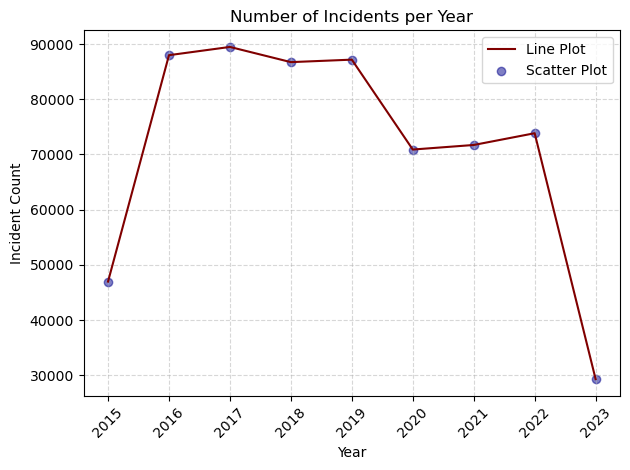

In [34]:
# Create a figure and axis objects
fig, ax = plt.subplots()

result_pd = result.toPandas()
# Plotting the scatter plot
ax.scatter(result_pd['YEAR'], result_pd['incident_count'], color='darkblue', label='Scatter Plot', alpha=0.5)

# Plotting the line plot
ax.plot(result_pd['YEAR'], result_pd['incident_count'], color='maroon', linestyle='-', label='Line Plot')

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Incident Count')
ax.set_title('Number of Incidents per Year')

# Customize grid lines
ax.grid(True, linestyle='--', alpha=0.5)

# Customize tick labels rotation
ax.tick_params(axis='x', rotation=45)

# Display legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

### Unique District Names 

In [35]:
# Query to find unique district names
query = """
SELECT DISTINCT DISTRICT
FROM incidents
"""

unique_districts = spark.sql(query)
unique_districts.show()

+--------+
|DISTRICT|
+--------+
|      C6|
|    null|
|      B2|
|     C11|
|     E13|
|      B3|
|      E5|
|     A15|
|      A7|
|     D14|
|      D4|
|     E18|
|      A1|
|External|
+--------+



In [36]:
# Mapping of district codes to district names
district_mapping = {
    'A1': 'Downtown',
    'A15': 'Charlestown',
    'A7': 'East Boston',
    'B2': 'Roxbury',
    'B3': 'Mattapan',
    'C6': 'South Boston',
    'C11': 'Dorchester',
    'D4': 'South End',
    'D14': 'Brighton',
    'E5': 'West Roxbury',
    'E13': 'Jamaica Plain',
    'E18': 'Hyde Park'
}

# Create a mapping dictionary column
mapping_expr = create_map([lit(x) for x in chain(*district_mapping.items())])

# Rename district code to district name
df_with_district_name = df_with_monthname.withColumn('DISTRICT_NAME', mapping_expr[col('DISTRICT')])

# Display the DataFrame with district names
df_with_district_name.limit(5).toPandas()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,MONTHNAME,DISTRICT_NAME
0,020038446,1501,Firearm Violations,WEAPON VIOLATION - CARRY/ POSSESSING/ SALE/ TR...,B2,300,N,2020-06-03 01:15:00,2020,6,Wednesday,1,Part Two,WASHINGTON ST,42.323808,-71.089150,"(42.3238077563779, -71.0891502345332)",June,Roxbury
1,023844463,3115,Investigate Person,INVESTIGATE PERSON,C6,,N,2021-10-16 01:16:00,2021,10,Saturday,1,Part Three,G ST & E 8TH ST,NaN,NaN,None,October,South Boston
2,102095489,3115,Investigate Person,INVESTIGATE PERSON,E18,520,N,2019-11-25 16:30:00,2019,11,Monday,16,Part Three,POYDRAS ST,42.256216,-71.124019,"(42.256215920402155, -71.12401947329023)",November,Hyde Park
3,120221042,3006,Medical Assistance,SICK/INJURED/MEDICAL - PERSON,E5,680,N,2021-04-02 10:45:00,2021,4,Friday,10,Part Three,WASHINGTON ST,42.283902,-71.130863,"(42.283902436483125, -71.13086262643496)",April,West Roxbury
4,121055112,3201,Property Lost,PROPERTY - LOST/ MISSING,E13,574,N,2021-08-07 21:45:00,2021,8,Saturday,21,Part Three,WASHINGTON ST,42.309719,-71.104294,"(42.30971856767274, -71.10429431787648)",August,Jamaica Plain


In [37]:
df_with_district_name.createOrReplaceTempView("incidents")

In [38]:
# Query to find unique district names
query = """
SELECT DISTINCT DISTRICT_NAME
FROM incidents
"""

unique_districts = spark.sql(query)
unique_districts.show()

+-------------+
|DISTRICT_NAME|
+-------------+
|     Brighton|
|      Roxbury|
|         null|
|    South End|
|  Charlestown|
|     Mattapan|
|   Dorchester|
|    Hyde Park|
|     Downtown|
| South Boston|
| West Roxbury|
|Jamaica Plain|
|  East Boston|
+-------------+



### Volume of Incidents by Offences

In [39]:
# Execute the SQL query
result = spark.sql("""
SELECT OFFENSE_CODE_GROUP, 
       COUNT(*) as num_incidents, 
       (COUNT(*) / (SELECT COUNT(*) FROM incidents)) * 100 as percentage
FROM incidents
GROUP BY OFFENSE_CODE_GROUP
ORDER BY num_incidents DESC
LIMIT 15
""")

# Convert to Pandas DataFrame for plotting
result_pd = result.toPandas()


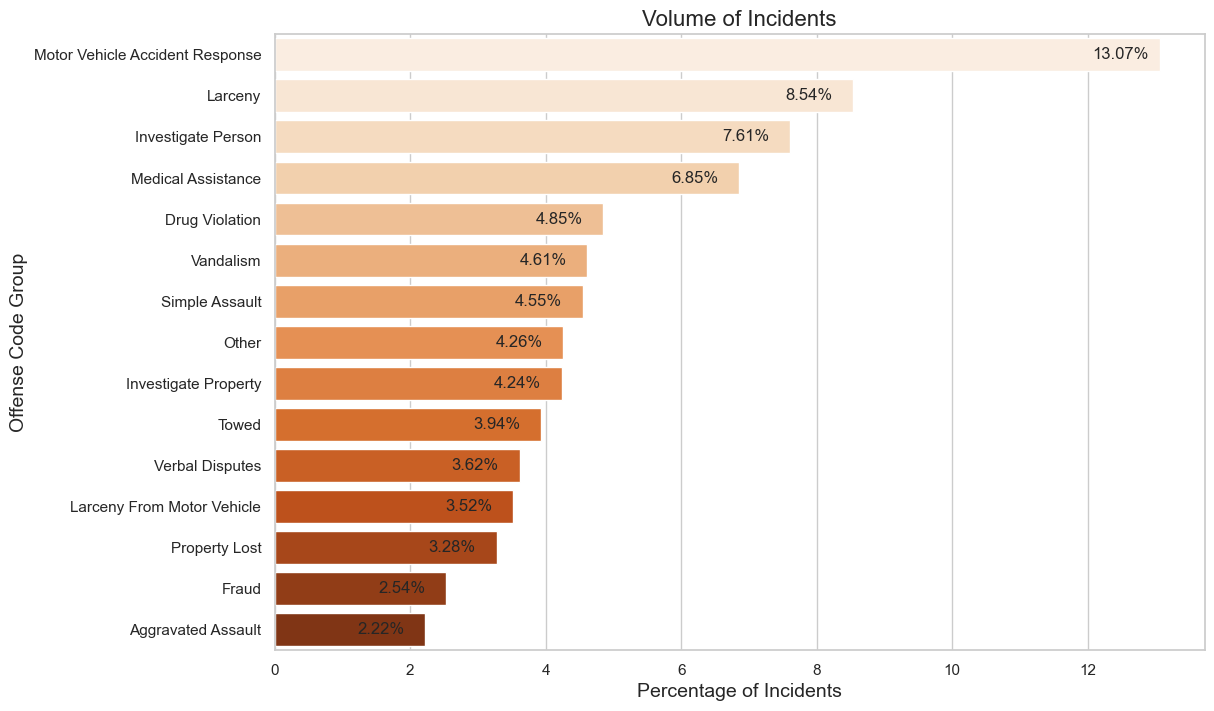

In [40]:
# Set the theme for better aesthetics
sns.set_theme(style="whitegrid")

# Increase the figure size for better visibility
plt.figure(figsize=(12, 8))

# Create a barplot
barplot = sns.barplot(x='percentage', y='OFFENSE_CODE_GROUP', data=result_pd, palette="Oranges")

# Add labels to the plot
for p in barplot.patches:
    width = p.get_width()
    plt.text(width-1,  # set the text at 1 unit left of the bar end
             p.get_y() + p.get_height() / 2,
             '{:1.2f}%'.format(width),  # format the value
             ha = 'left',  # horizontal alignment can be left, right or center
             va = 'center')  # vertical alignment can be top, bottom or center

# Set labels
plt.xlabel('Percentage of Incidents', fontsize=14)
plt.ylabel('Offense Code Group', fontsize=14)
plt.title('Volume of Incidents', fontsize=16)

plt.show()

### Count of Incidents by Severity YOY

In [41]:
# Execute the SQL query (excluding rows where UCR_PART is 'NAN' or NULL)
result = spark.sql("""
SELECT YEAR, 
       UCR_PART,
       COUNT(INCIDENT_NUMBER) as num_incidents
FROM incidents
WHERE UCR_PART IS NOT NULL AND UCR_PART != 'NAN'
GROUP BY YEAR, UCR_PART
""")

# Pivot the DataFrame so that each UCR_PART is a separate column
pandas_df = result.toPandas().pivot(index='YEAR', columns='UCR_PART', values='num_incidents')

# Fill null values with zeros
pandas_df = pandas_df.fillna(0)

# Convert 'YEAR' to string to avoid issues with matplotlib
pandas_df.index = pandas_df.index.astype(str)


pandas_df

UCR_PART,Other,Part One,Part Three,Part Two
YEAR,,,,
2015,119,10955,21553,14339
2016,264,17262,45395,25049
2017,337,16184,49205,23734
2018,310,15588,47469,23357
2019,247,16427,44927,23862
2020,228,14851,32078,18982
2021,260,13187,35689,17236
2022,289,13155,37921,22034
2023,121,4839,14648,9508


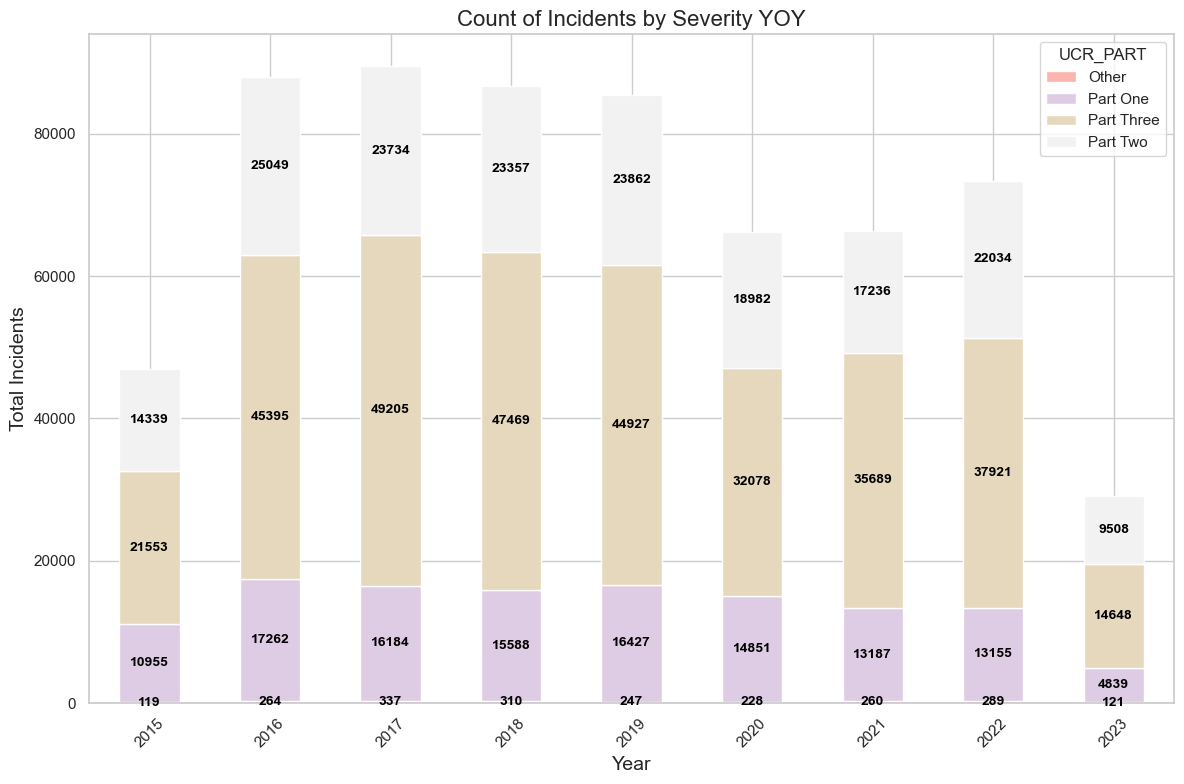

In [42]:
# Plot the results using a stacked bar plot
fig, ax = plt.subplots(figsize=(12, 8))
bars = pandas_df.plot(kind='bar', stacked=True, ax=ax, colormap='Pastel1')

# Adding the text labels for each stack
for rect_stack in ax.containers:
    for rect in rect_stack:
        # Find where everything is located
        height = rect.get_height()
        x = rect.get_x() + rect.get_width() / 2

        # Place the label
        ax.text(x, rect.get_y() + height / 2, 
                f'{int(height)}', ha='center', va='center', 
                color='black', fontsize=10, fontweight='bold')

# Set labels
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Incidents', fontsize=14)
plt.title('Count of Incidents by Severity YOY', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Incident Count By Month 

In [43]:
# Execute the SQL query
result = spark.sql("""
SELECT MONTHNAME, COUNT(INCIDENT_NUMBER) as num_incidents
FROM incidents
GROUP BY MONTHNAME
""")

# Convert to pandas DataFrame
pandas_df = result.toPandas()

# Sort DataFrame by month name in the calendar order
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']
pandas_df['MONTHNAME'] = pd.Categorical(pandas_df['MONTHNAME'], categories=months_order, ordered=True)
pandas_df = pandas_df.sort_values('MONTHNAME')

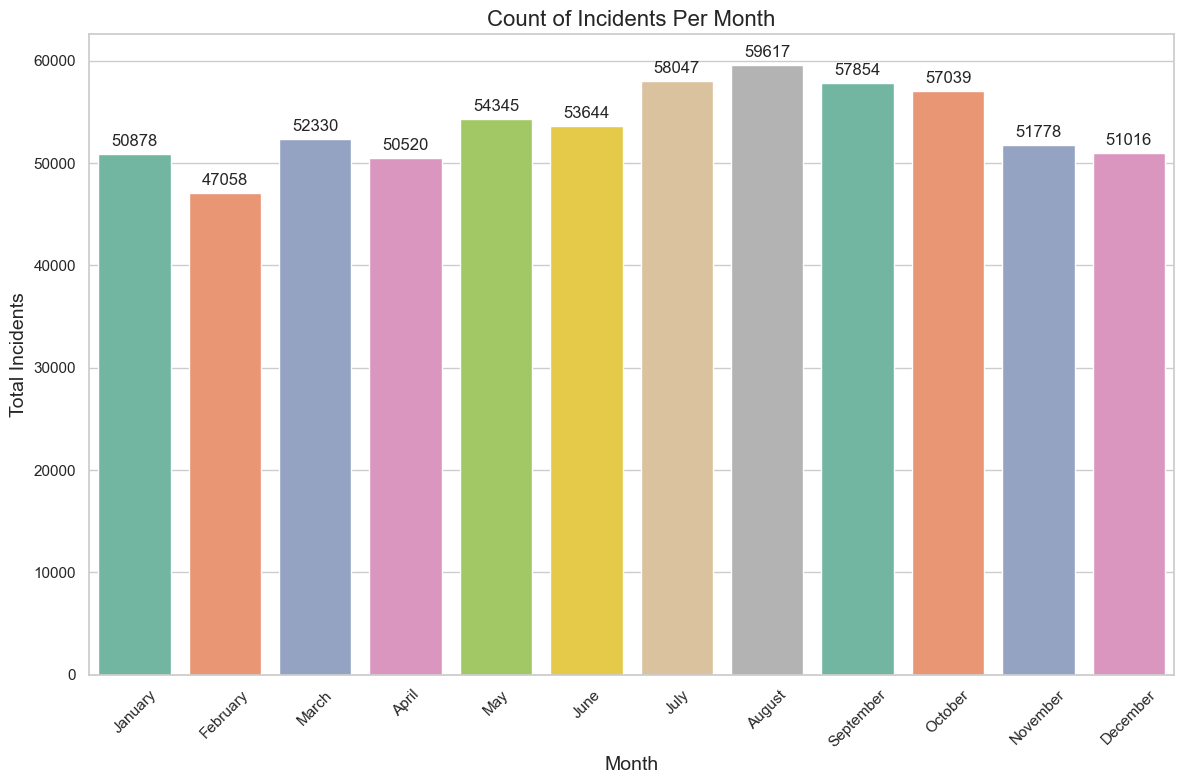

In [44]:
# Plot the results using a bar plot
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='MONTHNAME', y='num_incidents', data=pandas_df, palette='Set2')

# Add counts on the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points')

plt.title('Count of Incidents Per Month', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Incidents', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Top 5 Offenses per month

In [45]:
# Execute the SQL query to find the top 5 offenses
top_offenses = spark.sql("""
SELECT OFFENSE_CODE_GROUP, COUNT(INCIDENT_NUMBER) as total_incidents
FROM incidents
GROUP BY OFFENSE_CODE_GROUP
ORDER BY total_incidents DESC
LIMIT 5
""").rdd.map(lambda row: row.OFFENSE_CODE_GROUP).collect()

# Include top offenses in SQL query to count the monthly incidents
placeholders = ', '.join(["'" + offense + "'" for offense in top_offenses])
result = spark.sql(f"""
SELECT MONTHNAME, OFFENSE_CODE_GROUP, COUNT(INCIDENT_NUMBER) as num_incidents
FROM incidents
WHERE OFFENSE_CODE_GROUP IN ({placeholders})
GROUP BY MONTHNAME, OFFENSE_CODE_GROUP
""")

# Convert to pandas DataFrame and pivot
pandas_df = result.toPandas()
pandas_df = pandas_df.pivot(index='MONTHNAME', columns='OFFENSE_CODE_GROUP', values='num_incidents')

# Sort DataFrame by month name in the calendar order
months_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                'July', 'August', 'September', 'October', 'November', 'December']
pandas_df = pandas_df.reindex(months_order)
pandas_df

OFFENSE_CODE_GROUP,Drug Violation,Investigate Person,Larceny,Medical Assistance,Motor Vehicle Accident Response
MONTHNAME,,,,,
January,2853,3589,4369,3644,6580
February,2860,3384,3754,3240,6177
March,3158,4038,4068,3917,6763
April,2832,3953,4109,3667,6410
May,2862,4249,4278,3966,6951
June,2430,3772,4451,3742,6787
July,2509,4155,5185,4005,7296
August,2438,4378,5384,3851,7741
September,2386,4625,5112,3843,7516


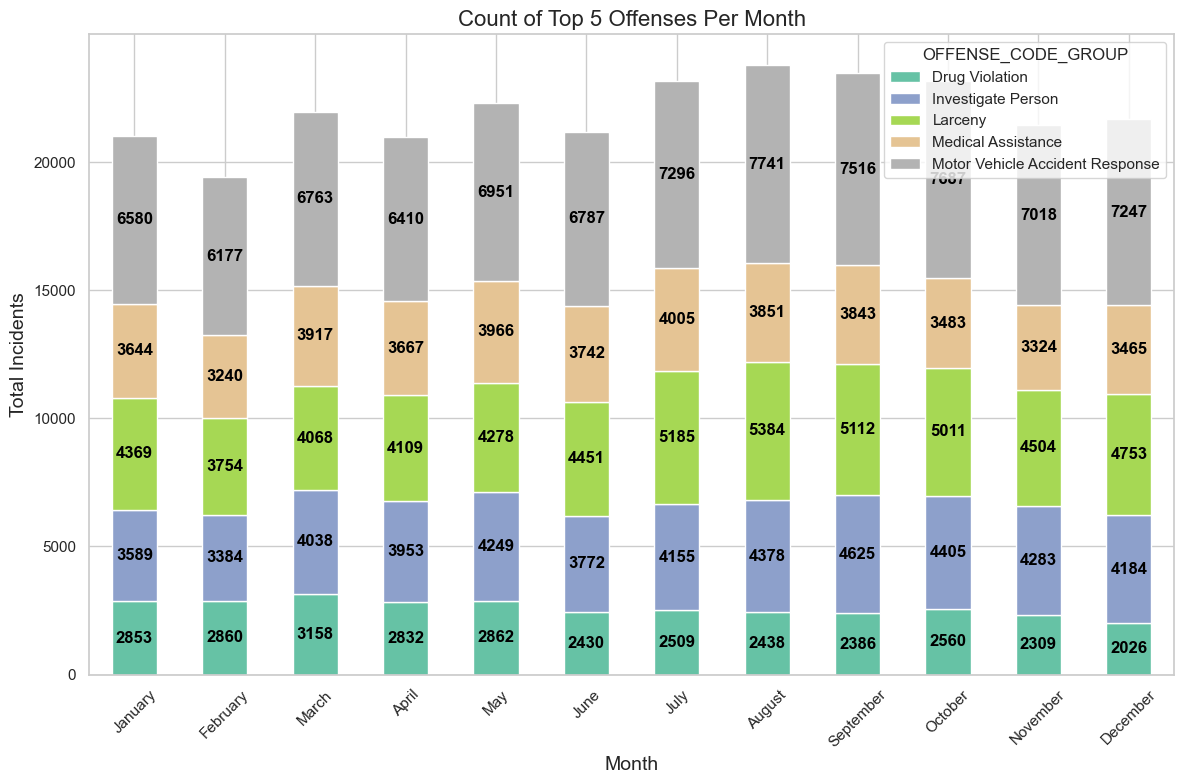

In [46]:
# Plot the results using a stacked bar plot
fig, ax = plt.subplots(figsize=(12, 8))
pandas_df.plot(kind='bar', stacked=True, ax=ax, colormap='Set2')

# Calculate cumulative totals for positioning the labels
cumulative_totals = pandas_df.cumsum(axis=1)

for i in range(len(pandas_df)):
    for j in range(len(pandas_df.columns)):
        if not np.isnan(pandas_df.iloc[i,j]):
            label_position = cumulative_totals.iloc[i,j] - (0.5 * pandas_df.iloc[i,j])
            ax.text(i, label_position, int(pandas_df.iloc[i,j]), ha='center', va='center', color='black', fontweight='bold')

# Set labels
plt.xlabel('Month', fontsize=14)
plt.ylabel('Total Incidents', fontsize=14)
plt.title('Count of Top 5 Offenses Per Month', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

### Top 5 Offenses by weekday

In [47]:
placeholders = ', '.join(["'" + offense + "'" for offense in top_offenses])
result = spark.sql(f"""
SELECT DAY_OF_WEEK, OFFENSE_CODE_GROUP, COUNT(INCIDENT_NUMBER) as num_incidents
FROM incidents
WHERE OFFENSE_CODE_GROUP IN ({placeholders})
GROUP BY DAY_OF_WEEK, OFFENSE_CODE_GROUP
""")

pandas_df = result.toPandas()
pandas_df = pandas_df.pivot(index='DAY_OF_WEEK', columns='OFFENSE_CODE_GROUP', values='num_incidents')

# Sort DataFrame by day of week in order
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pandas_df = pandas_df.reindex(days_order)

pandas_df

OFFENSE_CODE_GROUP,Drug Violation,Investigate Person,Larceny,Medical Assistance,Motor Vehicle Accident Response
DAY_OF_WEEK,,,,,
Monday,4752,6997,8005,6556,11596
Tuesday,4920,7105,8083,6527,11716
Wednesday,5116,7398,8140,6614,11855
Thursday,5043,7318,7991,6491,12070
Friday,4961,7535,8531,6480,13374
Saturday,3692,6526,7645,5856,12446
Sunday,2739,6136,6583,5623,11116


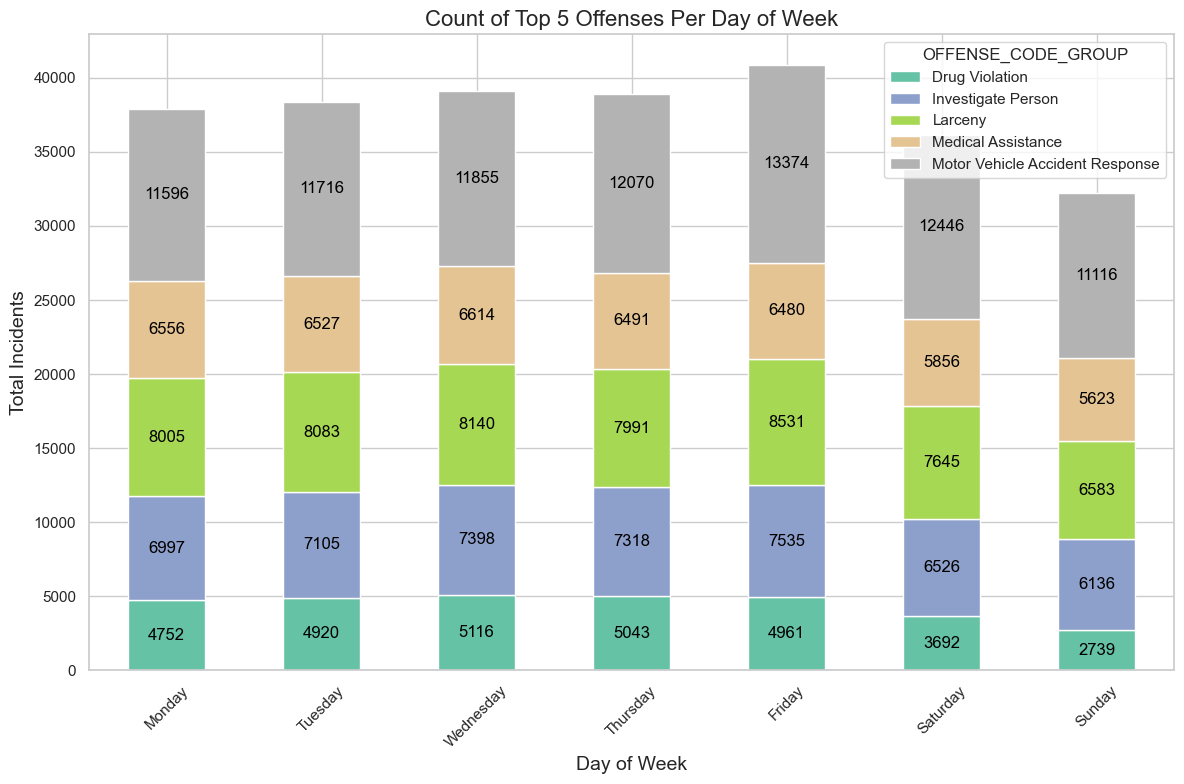

In [48]:
# Plot the results using a stacked bar plot
fig, ax = plt.subplots(figsize=(12, 8))
pandas_df.plot(kind='bar', stacked=True, ax=ax, colormap='Set2')

# Calculate cumulative totals for positioning the labels
cumulative_totals = pandas_df.cumsum(axis=1)

for i in range(len(pandas_df)):
    for j in range(len(pandas_df.columns)):
        if not np.isnan(pandas_df.iloc[i,j]):
            label_position = cumulative_totals.iloc[i,j] - (0.5 * pandas_df.iloc[i,j])
            ax.text(i, label_position, int(pandas_df.iloc[i,j]), ha='center', va='center', color='black')

plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Total Incidents', fontsize=14)
plt.title('Count of Top 5 Offenses Per Day of Week', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


### Total Incidents by hour 

In [49]:
# Execute the SQL query to find the total incidents by hour
result = spark.sql("""
SELECT HOUR, COUNT(INCIDENT_NUMBER) as num_incidents
FROM incidents
GROUP BY HOUR
ORDER BY HOUR
""")

# Convert the results to a pandas DataFrame
result_pd = result.toPandas()

result_pd

,HOUR,num_incidents
0,0,37389
1,1,17046
2,2,14676
3,3,9112
4,4,6753
5,5,7034
6,6,9976
7,7,17985
8,8,26354
9,9,29863


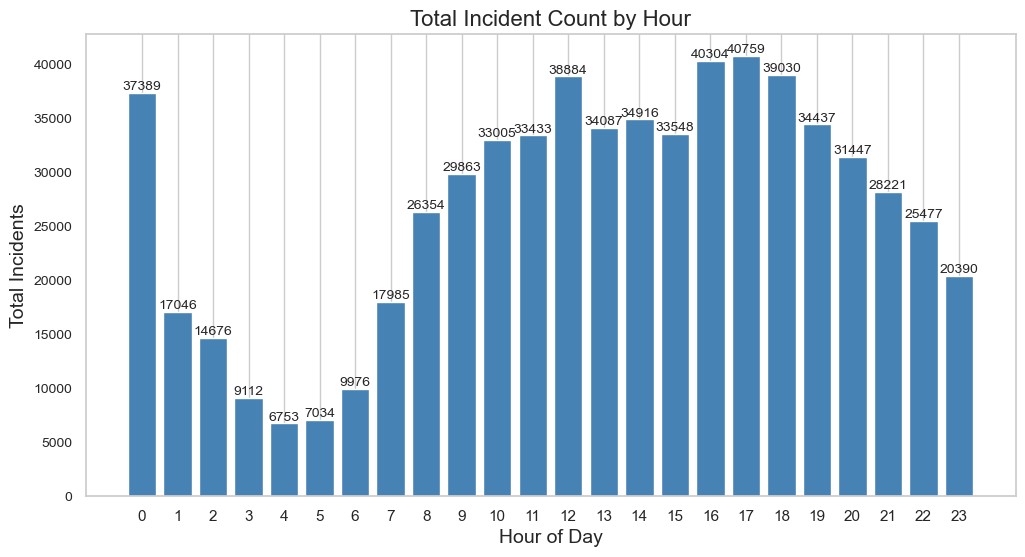

In [50]:
# Plot the results using a bar chart
plt.figure(figsize=(12, 6))
barplot = plt.bar(result_pd['HOUR'], result_pd['num_incidents'], color='steelblue')

# Add count labels to the bars
for bar in barplot:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height}', ha='center', va='bottom', fontsize=10)

plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Total Incidents', fontsize=14)
plt.title('Total Incident Count by Hour', fontsize=16)
plt.xticks(range(24))
plt.yticks(fontsize=10)
plt.grid(axis='y')

plt.show()

### Percentage of Incidents by Streets

In [51]:
sql_query = """
    SELECT STREET, COUNT(*) AS INCIDENT_COUNT, 
           ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM incidents WHERE STREET IS NOT NULL), 2) AS PERCENTAGE
    FROM incidents
    WHERE STREET IS NOT NULL
    GROUP BY STREET
    HAVING COUNT(*) > 0
    ORDER BY INCIDENT_COUNT DESC
    LIMIT 15
"""
result_df = spark.sql(sql_query)

result_pandas_df = result_df.toPandas()
result_pandas_df

,STREET,INCIDENT_COUNT,PERCENTAGE
0,WASHINGTON ST,34967,5.52
1,BLUE HILL AVE,16347,2.58
2,BOYLSTON ST,11892,1.88
3,HARRISON AVE,11485,1.81
4,CENTRE ST,10356,1.63
5,TREMONT ST,9110,1.44
6,DORCHESTER AVE,8951,1.41
7,MASSACHUSETTS AVE,8522,1.34
8,HYDE PARK AVE,8383,1.32
9,COMMONWEALTH AVE,8033,1.27


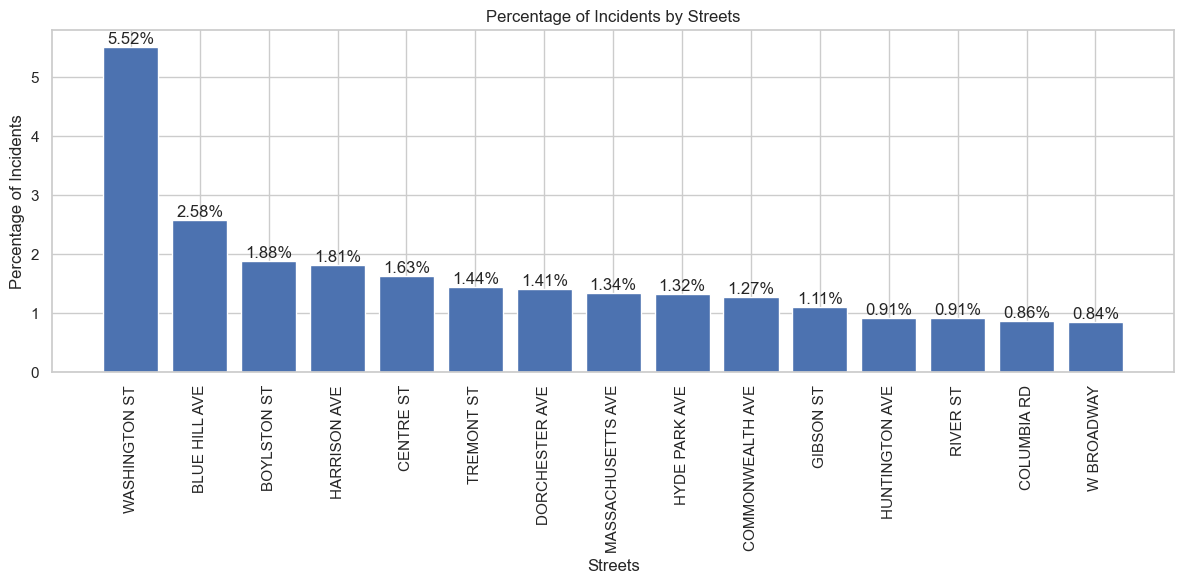

In [52]:
# Plotting the percentage of incidents using a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(result_pandas_df['STREET'], result_pandas_df['PERCENTAGE'])
plt.xlabel('Streets')
plt.ylabel('Percentage of Incidents')
plt.xticks(rotation=90)
plt.title('Percentage of Incidents by Streets')
plt.tight_layout()

# Annotate the percentage on each bar
for bar in bars:
    percentage = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{percentage}%", ha='center', va='bottom')

plt.show()

### Percentage of Shootings by Streets

In [53]:
# Step 4: Write the SQL query
sql_query = """
    SELECT STREET, COUNT(*) AS SHOOTING_COUNT,
           ROUND(COUNT(*) * 100.0 / NULLIF((SELECT COUNT(*) FROM incidents WHERE SHOOTING = 'Y' AND STREET IS NOT NULL), 0), 2) AS PERCENTAGE
    FROM incidents
    WHERE SHOOTING = 'Y' AND STREET IS NOT NULL
    GROUP BY STREET
    HAVING COUNT(*) > 0
    ORDER BY SHOOTING_COUNT DESC
    LIMIT 15
"""

# Step 5: Execute the SQL query and retrieve the results
result_df = spark.sql(sql_query)

# Step 6: Convert the DataFrame to a Pandas DataFrame
result_pandas_df = result_df.toPandas()

result_pandas_df

,STREET,SHOOTING_COUNT,PERCENTAGE
0,WASHINGTON ST,150,3.38
1,BLUE HILL AVE,109,2.45
2,COLUMBIA RD,79,1.78
3,DUDLEY ST,49,1.10
4,CENTRE ST,47,1.06
5,DORCHESTER AVE,42,0.95
6,NORFOLK ST,40,0.90
7,MORTON ST,38,0.86
8,GENEVA AVE,38,0.86
9,TALBOT AVE,31,0.70


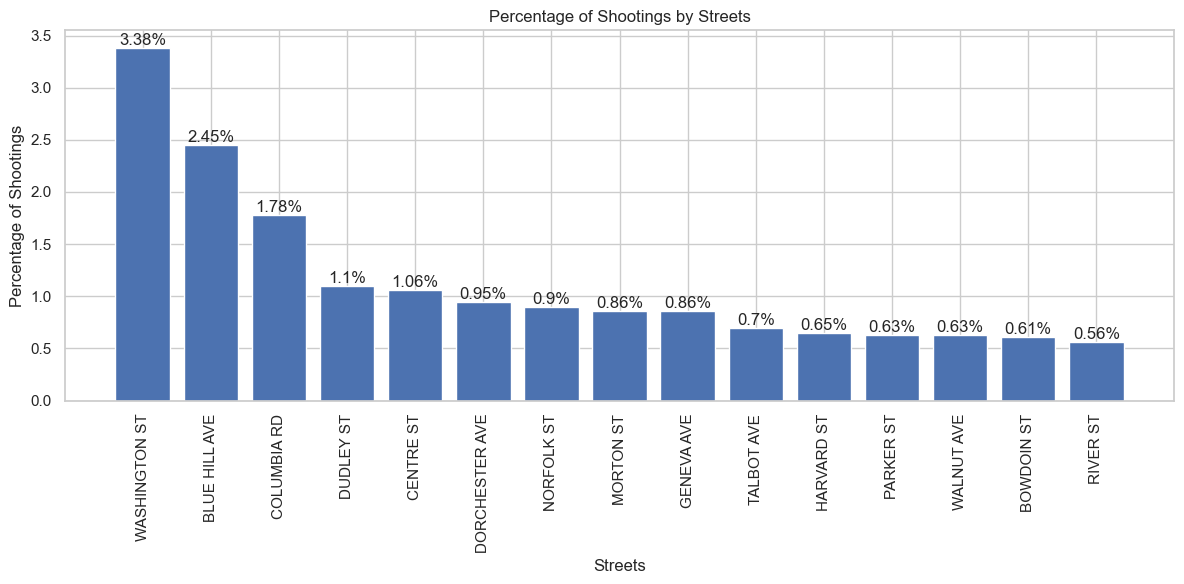

In [54]:
# Plotting the results using a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(result_pandas_df['STREET'], result_pandas_df['PERCENTAGE'])
plt.xlabel('Streets')
plt.ylabel('Percentage of Shootings')
plt.xticks(rotation=90)
plt.title('Percentage of Shootings by Streets')
plt.tight_layout()

# Annotate the percentage on each bar
for bar in bars:
    percentage = bar.get_height()
    if pd.notnull(percentage):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{percentage}%", ha='center', va='bottom')

plt.show()

### Percentage of Incidents by District

In [55]:
# Step 4: Write a SQL query to calculate the percentage of incidents by district
sql_query = """
    SELECT DISTRICT_NAME, COUNT(*) AS INCIDENT_COUNT, 
           ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM incidents WHERE DISTRICT_NAME IS NOT NULL), 2) AS PERCENTAGE
    FROM incidents
    WHERE DISTRICT_NAME IS NOT NULL
    GROUP BY DISTRICT_NAME
    ORDER BY INCIDENT_COUNT DESC
"""

# Step 5: Retrieve the results of the query as a new DataFrame
result_df = spark.sql(sql_query)

# Step 6: Convert the DataFrame to a Pandas DataFrame
result_pandas_df = result_df.toPandas()

result_pandas_df

,DISTRICT_NAME,INCIDENT_COUNT,PERCENTAGE
0,Roxbury,95667,14.96
1,Dorchester,83238,13.02
2,South End,83097,13.00
3,Downtown,71117,11.12
4,Mattapan,70203,10.98
5,South Boston,49370,7.72
6,Brighton,43691,6.83
7,Hyde Park,36408,5.69
8,Jamaica Plain,36020,5.63
9,West Roxbury,28918,4.52


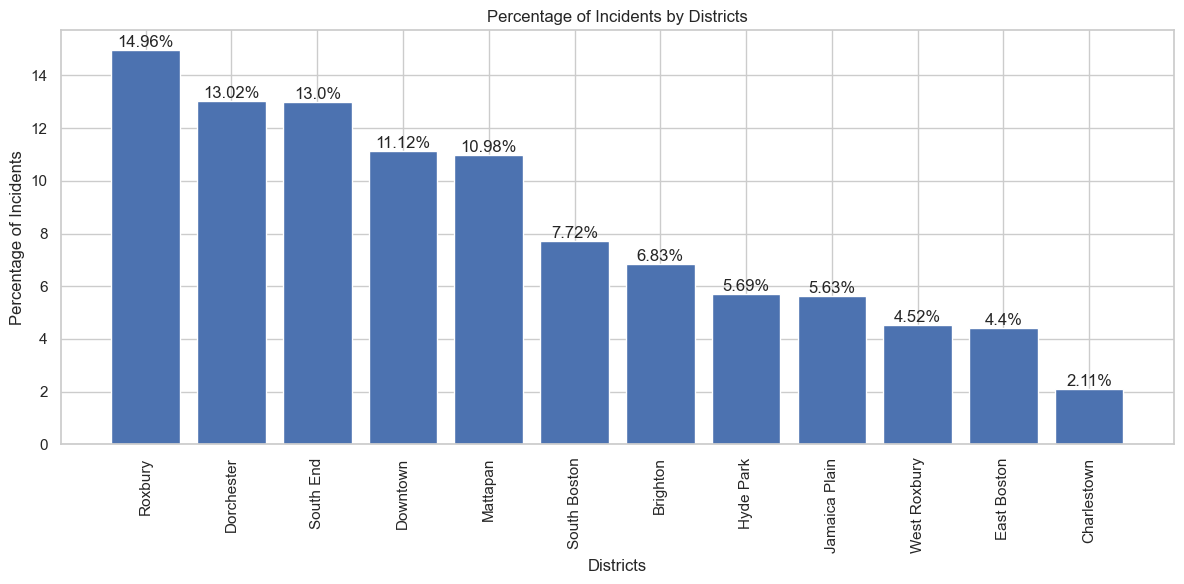

In [56]:
# Plotting the results using a bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(result_pandas_df['DISTRICT_NAME'], result_pandas_df['PERCENTAGE'])
plt.xlabel('Districts')
plt.ylabel('Percentage of Incidents')
plt.xticks(rotation=90)
plt.title('Percentage of Incidents by Districts')
plt.tight_layout()

# Annotate the percentage on each bar
for bar in bars:
    percentage = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{percentage}%", ha='center', va='bottom')

plt.show()


### Percentage of Shootings by District

In [57]:
sql_query = """
    SELECT DISTRICT_NAME, COUNT(*) AS SHOOTING_COUNT,
           ROUND(COUNT(*) * 100.0 / NULLIF((SELECT COUNT(*) FROM incidents WHERE SHOOTING = 'Y' AND DISTRICT_NAME IS NOT NULL), 0), 2) AS PERCENTAGE
    FROM incidents
    WHERE SHOOTING = 'Y' AND DISTRICT_NAME IS NOT NULL
    GROUP BY DISTRICT_NAME
    ORDER BY SHOOTING_COUNT DESC
"""

# Step 5: Retrieve the results of the query as a new DataFrame
result_df = spark.sql(sql_query)

# Step 6: Convert the DataFrame to a Pandas DataFrame
result_pandas_df = result_df.toPandas()
result_pandas_df

,DISTRICT_NAME,SHOOTING_COUNT,PERCENTAGE
0,Roxbury,1217,27.42
1,Mattapan,1162,26.18
2,Dorchester,859,19.36
3,Jamaica Plain,252,5.68
4,Hyde Park,241,5.43
5,South End,211,4.75
6,South Boston,152,3.42
7,West Roxbury,87,1.96
8,East Boston,86,1.94
9,Brighton,73,1.64


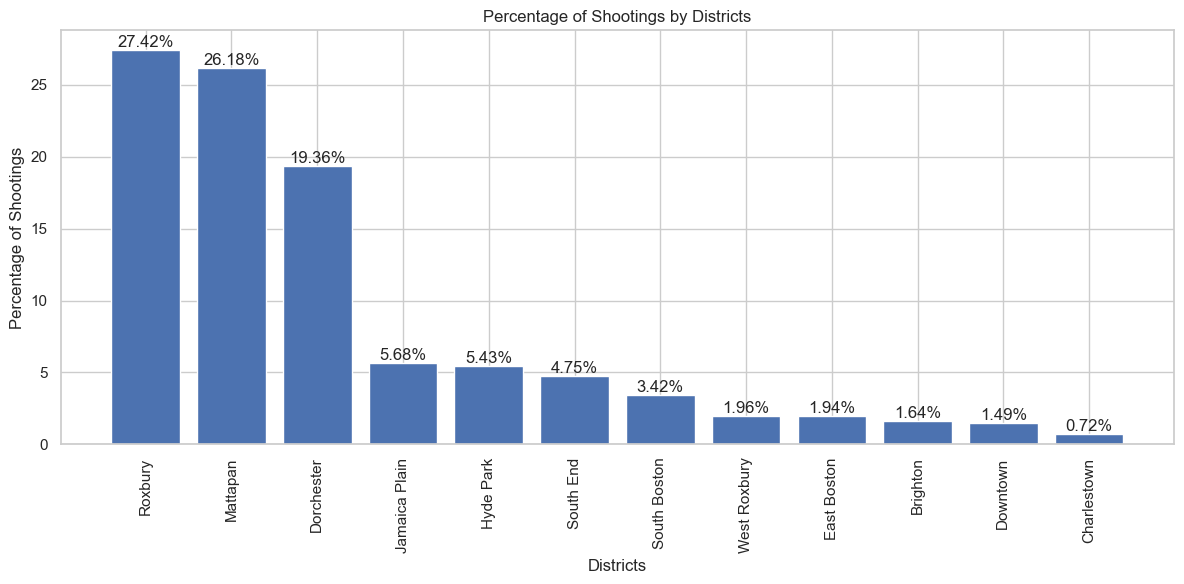

In [58]:
plt.figure(figsize=(12, 6))
bars = plt.bar(result_pandas_df['DISTRICT_NAME'], result_pandas_df['PERCENTAGE'])
plt.xlabel('Districts')
plt.ylabel('Percentage of Shootings')
plt.xticks(rotation=90)
plt.title('Percentage of Shootings by Districts')
plt.tight_layout()

# Annotate the percentage on each bar
for bar in bars:
    percentage = bar.get_height()
    if pd.notnull(percentage):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{percentage}%", ha='center', va='bottom')

plt.show()

### Total Incidents by Severity Per District 

In [59]:
sql_query = """
    SELECT DISTRICT_NAME, UCR_PART, COUNT(*) AS INCIDENT_COUNT
    FROM incidents
    WHERE UCR_PART IS NOT NULL AND DISTRICT_NAME IS NOT NULL
    GROUP BY DISTRICT_NAME, UCR_PART
    ORDER BY DISTRICT_NAME, UCR_PART
"""

# Step 5: Retrieve the results of the query as a new DataFrame
result_df = spark.sql(sql_query)

# Step 6: Convert the DataFrame to a Pandas DataFrame
result_pandas_df = result_df.toPandas()

# Pivot the DataFrame to have districts as the index, UCR_Part as the columns, and INCIDENT_COUNT as the values
pivot_df = result_pandas_df.pivot(index='DISTRICT_NAME', columns='UCR_PART', values='INCIDENT_COUNT')

pivot_df

UCR_PART,Other,Part One,Part Three,Part Two
DISTRICT_NAME,,,,
Brighton,93,8474,23711,10565
Charlestown,32,2457,7211,3539
Dorchester,348,13781,44476,23095
Downtown,126,17080,31786,20441
East Boston,153,4575,14690,8180
Hyde Park,104,5099,20928,9673
Jamaica Plain,84,6569,18753,9754
Mattapan,305,9655,38551,20414
Roxbury,398,15709,49444,28413


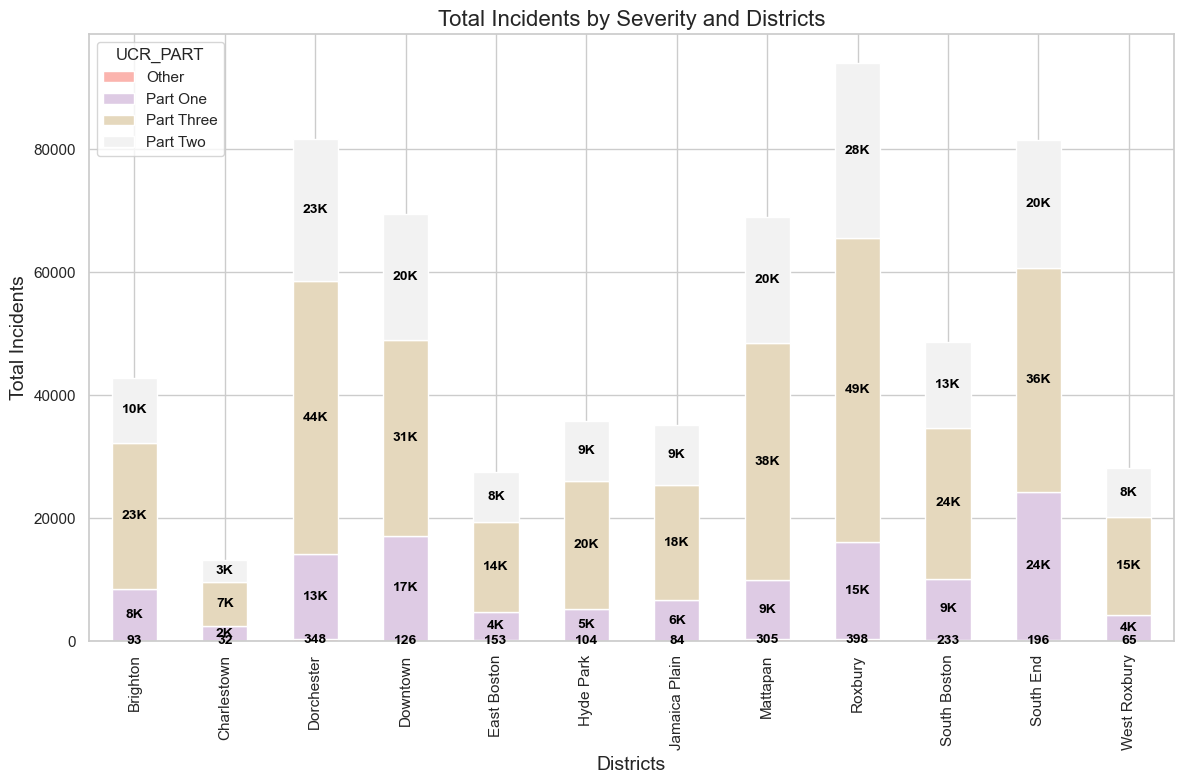

In [60]:
# Plot the results using a stacked bar plot
fig, ax = plt.subplots(figsize=(12, 8))
bars = pivot_df.plot(kind='bar', stacked=True, ax=ax, colormap='Pastel1')

# Adding the text labels for each stack
for rect_stack in ax.containers:
    for rect in rect_stack:
        # Find where everything is located
        height = rect.get_height()
        x = rect.get_x() + rect.get_width() / 2

        # Format the count label
        if height >= 1000:
            label = f"{int(height/1000)}K"
        else:
            label = str(int(height))

        # Place the label
        ax.text(x, rect.get_y() + height / 2, 
                label, ha='center', va='center', 
                color='black', fontsize=10, fontweight='bold')

# Set labels
plt.xlabel('Districts', fontsize=14)
plt.ylabel('Total Incidents', fontsize=14)
plt.title('Total Incidents by Severity and Districts', fontsize=16)
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()


In [61]:
sql_query = """
    SELECT DISTRICT_NAME, COUNT(*) AS OFFENSE_COUNT
    FROM incidents
    GROUP BY DISTRICT_NAME
    ORDER BY OFFENSE_COUNT DESC
"""

# Step 5: Retrieve the results of the query as a new DataFrame
result_df = spark.sql(sql_query)

# Step 6: Convert the DataFrame to a Pandas DataFrame
result_pandas_df = result_df.toPandas()
result_pandas_df

,DISTRICT_NAME,OFFENSE_COUNT
0,Roxbury,95667
1,Dorchester,83238
2,South End,83097
3,Downtown,71117
4,Mattapan,70203
5,South Boston,49370
6,Brighton,43691
7,Hyde Park,36408
8,Jamaica Plain,36020
9,West Roxbury,28918


### Modelling

Y - OFFENSE_CODE_GROUP

X - 'DISTRICT','REPORTING_AREA','MONTH','DAY_OF_WEEK', 'HOUR','Lat','Long', 'OFFENSE_CODE_GROUP'

In [62]:
df_pandas = df_with_district_name.toPandas()

In [63]:
df_pandas.head(5)

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location,MONTHNAME,DISTRICT_NAME
0,020038446,1501,Firearm Violations,WEAPON VIOLATION - CARRY/ POSSESSING/ SALE/ TR...,B2,300,N,2020-06-03 01:15:00,2020,6,Wednesday,1,Part Two,WASHINGTON ST,42.323808,-71.089150,"(42.3238077563779, -71.0891502345332)",June,Roxbury
1,023844463,3115,Investigate Person,INVESTIGATE PERSON,C6,,N,2021-10-16 01:16:00,2021,10,Saturday,1,Part Three,G ST & E 8TH ST,NaN,NaN,None,October,South Boston
2,102095489,3115,Investigate Person,INVESTIGATE PERSON,E18,520,N,2019-11-25 16:30:00,2019,11,Monday,16,Part Three,POYDRAS ST,42.256216,-71.124019,"(42.256215920402155, -71.12401947329023)",November,Hyde Park
3,120221042,3006,Medical Assistance,SICK/INJURED/MEDICAL - PERSON,E5,680,N,2021-04-02 10:45:00,2021,4,Friday,10,Part Three,WASHINGTON ST,42.283902,-71.130863,"(42.283902436483125, -71.13086262643496)",April,West Roxbury
4,121055112,3201,Property Lost,PROPERTY - LOST/ MISSING,E13,574,N,2021-08-07 21:45:00,2021,8,Saturday,21,Part Three,WASHINGTON ST,42.309719,-71.104294,"(42.30971856767274, -71.10429431787648)",August,Jamaica Plain


In [64]:
df_pandas['OFFENSE_CODE_GROUP'].value_counts().head(15)

Motor Vehicle Accident Response    84173
Larceny                            54978
Investigate Person                 49015
Medical Assistance                 44147
Drug Violation                     31223
Vandalism                          29725
Simple Assault                     29287
Other                              27428
Investigate Property               27280
Towed                              25355
Verbal Disputes                    23292
Larceny From Motor Vehicle         22666
Property Lost                      21104
Fraud                              16343
Aggravated Assault                 14300
Name: OFFENSE_CODE_GROUP, dtype: int64

In [65]:
list_offense_code_group = ('Motor Vehicle Accident Response',
                           'Larceny',
                           'Medical Assistance',
                           'Investigate Person',
                           'Other',
                           'Drug Violation',
                           'Simple Assault',
                           'Vandalism',
                           'Verbal Disputes',
                           'Towed',
                           'Investigate Property',
                           'Property Lost',
                           'Fraud',
                           'Aggravated Assault',
                           'Larceny From Motor Vehicle')

In [66]:
df_model = pd.DataFrame()

In [67]:
i = 0

while i < len(list_offense_code_group):
    df_model = df_model.append(df_pandas.loc[df_pandas['OFFENSE_CODE_GROUP'] == list_offense_code_group[i]])
    i+=1

In [68]:
list_column = ['DISTRICT','YEAR','MONTH','DAY_OF_WEEK',
               'HOUR','Lat','Long', 'OFFENSE_CODE_GROUP']

In [69]:
df_model = df_model[list_column]

In [70]:
df_model.head(5)

,DISTRICT,YEAR,MONTH,DAY_OF_WEEK,HOUR,Lat,Long,OFFENSE_CODE_GROUP
30,C11,2019,1,Tuesday,1,42.294009,-71.067495,Motor Vehicle Accident Response
35,C11,2019,1,Tuesday,2,NaN,NaN,Motor Vehicle Accident Response
44,C11,2019,1,Tuesday,13,42.297976,-71.070892,Motor Vehicle Accident Response
59,E13,2019,1,Wednesday,3,42.313887,-71.096834,Motor Vehicle Accident Response
63,A7,2019,1,Wednesday,16,42.385744,-71.011870,Motor Vehicle Accident Response


In [71]:
df_model['DISTRICT'] = df_model['DISTRICT'].map({
    'B3':1, 
    'E18':2, 
    'B2':3, 
    'E5':4, 
    'C6':5, 
    'D14':6, 
    'E13':7, 
    'C11':8, 
    'D4':9, 
    'A7':10, 
    'A1':11, 
    'A15':12
})

df_model['DISTRICT'].unique()

array([ 8.,  7., 10.,  4.,  3.,  5., 11.,  6.,  9.,  1., nan, 12.,  2.])

In [72]:
df_model['MONTH'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12'],
      dtype=object)

In [73]:
# DAY_OF_WEEK

df_model['DAY_OF_WEEK'] = df_model['DAY_OF_WEEK'].map({
    'Tuesday':2, 
    'Saturday':6, 
    'Monday':1, 
    'Sunday':7, 
    'Thursday':4, 
    'Wednesday':3,
    'Friday':5
})

df_model['DAY_OF_WEEK'].unique()

array([2, 3, 5, 6, 7, 1, 4])

In [74]:
df_model[['Lat', 'Long']].head()

,Lat,Long
30,42.294009,-71.067495
35,NaN,NaN
44,42.297976,-71.070892
59,42.313887,-71.096834
63,42.385744,-71.011870


In [75]:
df_model.fillna(0, inplace = True)
df_model.size

4002528

In [76]:
x = df_model[['DISTRICT','YEAR','MONTH','DAY_OF_WEEK',
               'HOUR','Lat','Long']]
y = df_model['OFFENSE_CODE_GROUP']

In [77]:
y.unique()

array(['Motor Vehicle Accident Response', 'Larceny', 'Medical Assistance',
       'Investigate Person', 'Other', 'Drug Violation', 'Simple Assault',
       'Vandalism', 'Verbal Disputes', 'Towed', 'Investigate Property',
       'Property Lost', 'Fraud', 'Aggravated Assault',
       'Larceny From Motor Vehicle'], dtype=object)

In [78]:
y = y.map({
    'Motor Vehicle Accident Response':1,
       'Larceny':2,
       'Medical Assistance':3,
       'Investigate Person':4,
       'Other':5,
       'Drug Violation':6,
       'Simple Assault':7,
       'Vandalism':8,
       'Verbal Disputes':9,
       'Towed':10,
       'Investigate Property':11,
       'Property Lost':12,
       'Fraud':13,
       'Aggravated Assault':14,
       'Larceny From Motor Vehicle':15
})

### Split the Data into Test and Train 

In [79]:
X_train, X_test, Y_train, Y_test = train_test_split(
    x,
    y, 
    test_size = 0.4,
    random_state=42
)

print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(300189, 7) (300189,)
(200127, 7) (200127,)


In [80]:
def fun_results(result):
    print('mean: ' + str(result.mean()))
    print('max: ' + str(result.max()))
    print('min: ' + str(result.min()))
    return result

In [81]:
# Drop rows with missing values
X_train.dropna(inplace=True)
Y_train.dropna(inplace=True)

# Fill missing values with a specific value
X_train.fillna(0, inplace=True)
Y_train.fillna(0, inplace=True)

print(X_train.shape)
print(Y_train.shape)


(300189, 7)
(300189,)


In [82]:
!pip install -U lightgbm

In [84]:
# DecisionTreeClassifier

def fun_DecisionTreeClassifier(X_train, Y_train):
    dec_tree = DecisionTreeClassifier()
    dec_tree = dec_tree.fit(X_train, Y_train)

    dec_tree_pred = dec_tree.predict(X_test)

    dec_tree_score = f1_score(Y_test, dec_tree_pred, average=None)
    return fun_results(dec_tree_score)

fun_DecisionTreeClassifier(X_train, Y_train)

mean: 0.14694090950835925
max: 0.2833514591263368
min: 0.05094991364421416


array([0.26946841, 0.28335146, 0.14891882, 0.13764095, 0.08899107,
       0.2310303 , 0.09061075, 0.09165029, 0.10471538, 0.23661718,
       0.16115266, 0.08747491, 0.12365675, 0.05094991, 0.09788479])

In [85]:
# BernoulliNB

def fun_BernoulliNB(X_train, Y_train):
    bernoulli = BernoulliNB()
    bernoulli = bernoulli.fit(X_train, Y_train)

    bernoulli_pred = bernoulli.predict(X_test)

    bernoulli_score = f1_score(Y_test, bernoulli_pred, average=None)
    return fun_results(bernoulli_score)

fun_BernoulliNB(X_train, Y_train)

mean: 0.02763113779509087
max: 0.2917185679270302
min: 0.0


array([0.29171857, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.1227485 , 0.        , 0.        ])

In [86]:
# ExtraTreeClassifier

def fun_ExtraTreeClassifier(X_train, Y_train):
    ext_tree = ExtraTreeClassifier()
    ext_tree = ext_tree.fit(X_train, Y_train)

    ext_tree_pred = ext_tree.predict(X_test)

    ext_tree_score = f1_score(Y_test, ext_tree_pred, average=None)
    return fun_results(ext_tree_score)

fun_ExtraTreeClassifier(X_train, Y_train)

mean: 0.12101655563199057
max: 0.2463919497447516
min: 0.03978076379066478


array([0.24639195, 0.21856361, 0.12455022, 0.12443717, 0.08039925,
       0.18283389, 0.08189451, 0.0838707 , 0.08750882, 0.163658  ,
       0.12658694, 0.0693081 , 0.10638625, 0.03978076, 0.07907817])

In [87]:
# KNeighborsClassifier

def fun_KNeighborsClassifier(X_train, Y_train):
    neigh = KNeighborsClassifier()
    neigh.fit(X_train, Y_train) 

    neigh_pred = neigh.predict(X_test)

    neigh_score = f1_score(Y_test, neigh_pred, average=None)
    return fun_results(neigh_score)

fun_KNeighborsClassifier(X_train, Y_train)

mean: 0.11025170344930572
max: 0.29728497100680384
min: 0.018699413898967343


array([0.29728497, 0.22733593, 0.12777989, 0.12474268, 0.0598405 ,
       0.14602787, 0.06374547, 0.05898972, 0.06623094, 0.17457831,
       0.09221722, 0.04505504, 0.10569692, 0.01869941, 0.04555068])

In [88]:
# GaussianNB

def fun_GaussianNB(X_train, Y_train):
    gauss = GaussianNB()
    gauss = gauss.fit(X_train, Y_train)

    gauss_pred = gauss.predict(X_test)

    gauss_score = f1_score(Y_test, gauss_pred, average=None)
    return fun_results(gauss_score)

fun_GaussianNB(X_train, Y_train)

mean: 0.06240005120711645
max: 0.3001407789770061
min: 0.0


array([0.30014078, 0.24408833, 0.04380823, 0.14487419, 0.        ,
       0.        , 0.        , 0.        , 0.12976461, 0.        ,
       0.        , 0.        , 0.07332463, 0.        , 0.        ])

In [89]:
# Define a function to compute the F1 scores and store the results
def compute_f1_scores(models, X_train, Y_train):
    results = {}
    for model_name, model in models.items():
        # Fit the model
        model.fit(X_train, Y_train)

        # Predict on the test set
        y_pred = model.predict(X_test)

        # Compute the F1 score
        f1 = f1_score(Y_test, y_pred, average=None)

        # Store the F1 scores in the results dictionary
        results[model_name] = f1.tolist()  # Convert to list

    return results

# Define the models
models = {
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'BernoulliNB': BernoulliNB(),
    'ExtraTreeClassifier': ExtraTreeClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'GaussianNB': GaussianNB()
}

# Call the function to compute the F1 scores
f1_scores = compute_f1_scores(models, X_train, Y_train)

# Create a DataFrame from the F1 scores
df_f1_scores = pd.DataFrame.from_dict(f1_scores, orient='index')

# Print the DataFrame
display(df_f1_scores)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
DecisionTreeClassifier,0.270823,0.279699,0.146612,0.138478,0.090881,0.230701,0.090294,0.090909,0.102260,0.233128,0.157953,0.085977,0.124806,0.054339,0.096953
BernoulliNB,0.291719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.122748,0.000000,0.000000
ExtraTreeClassifier,0.245820,0.223781,0.126021,0.126859,0.078338,0.194845,0.078205,0.084072,0.084005,0.167401,0.127021,0.065068,0.114529,0.044448,0.079470
KNeighborsClassifier,0.297285,0.227336,0.127780,0.124743,0.059841,0.146028,0.063745,0.058990,0.066231,0.174578,0.092217,0.045055,0.105697,0.018699,0.045551
GaussianNB,0.300141,0.244088,0.043808,0.144874,0.000000,0.000000,0.000000,0.000000,0.129765,0.000000,0.000000,0.000000,0.073325,0.000000,0.000000


<Figure size 1200x800 with 0 Axes>

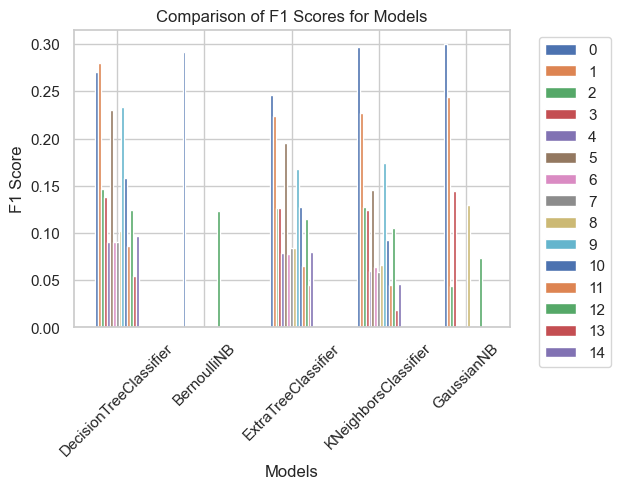

In [113]:
# Assuming you have a DataFrame named df_f1_scores containing the F1 scores
df_f1_scores = pd.DataFrame.from_dict(f1_scores, orient='index')

# Plotting the F1 scores
plt.figure(figsize=(12, 8))  # Adjust the figure size as per your preference
ax = df_f1_scores.plot(kind='bar', rot=45)  # Rotate x-labels by 45 degrees
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores for Models')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Adjust the spacing between subplots to accommodate long x-labels
plt.subplots_adjust(bottom=0.3)  # Increase or decrease the bottom spacing as needed

# Display the plot
plt.show()

### Clustering 

In [90]:
location = df_pandas[['Lat','Long']]
location = location.dropna()

location = location.loc[(location['Lat']>40) & (location['Long'] < -60)] 

In [91]:
x = location['Long']
y = location['Lat']


colors = np.random.rand(len(x))

plt.figure(figsize=(20,20))
plt.scatter(x, y,c=colors, alpha=0.5)
plt.show()

In [92]:
X = location
X = X[~np.isnan(X)]

In [93]:
#K means Clustering #K means  
def doKmeans(X, nclust):
    model = KMeans(nclust)
    model.fit(X)
    clust_labels = model.predict(X)
    cent = model.cluster_centers_
    return (clust_labels, cent)

clust_labels, cent = doKmeans(X, 2)
kmeans = pd.DataFrame(clust_labels)
X.insert((X.shape[1]),'kmeans',kmeans)

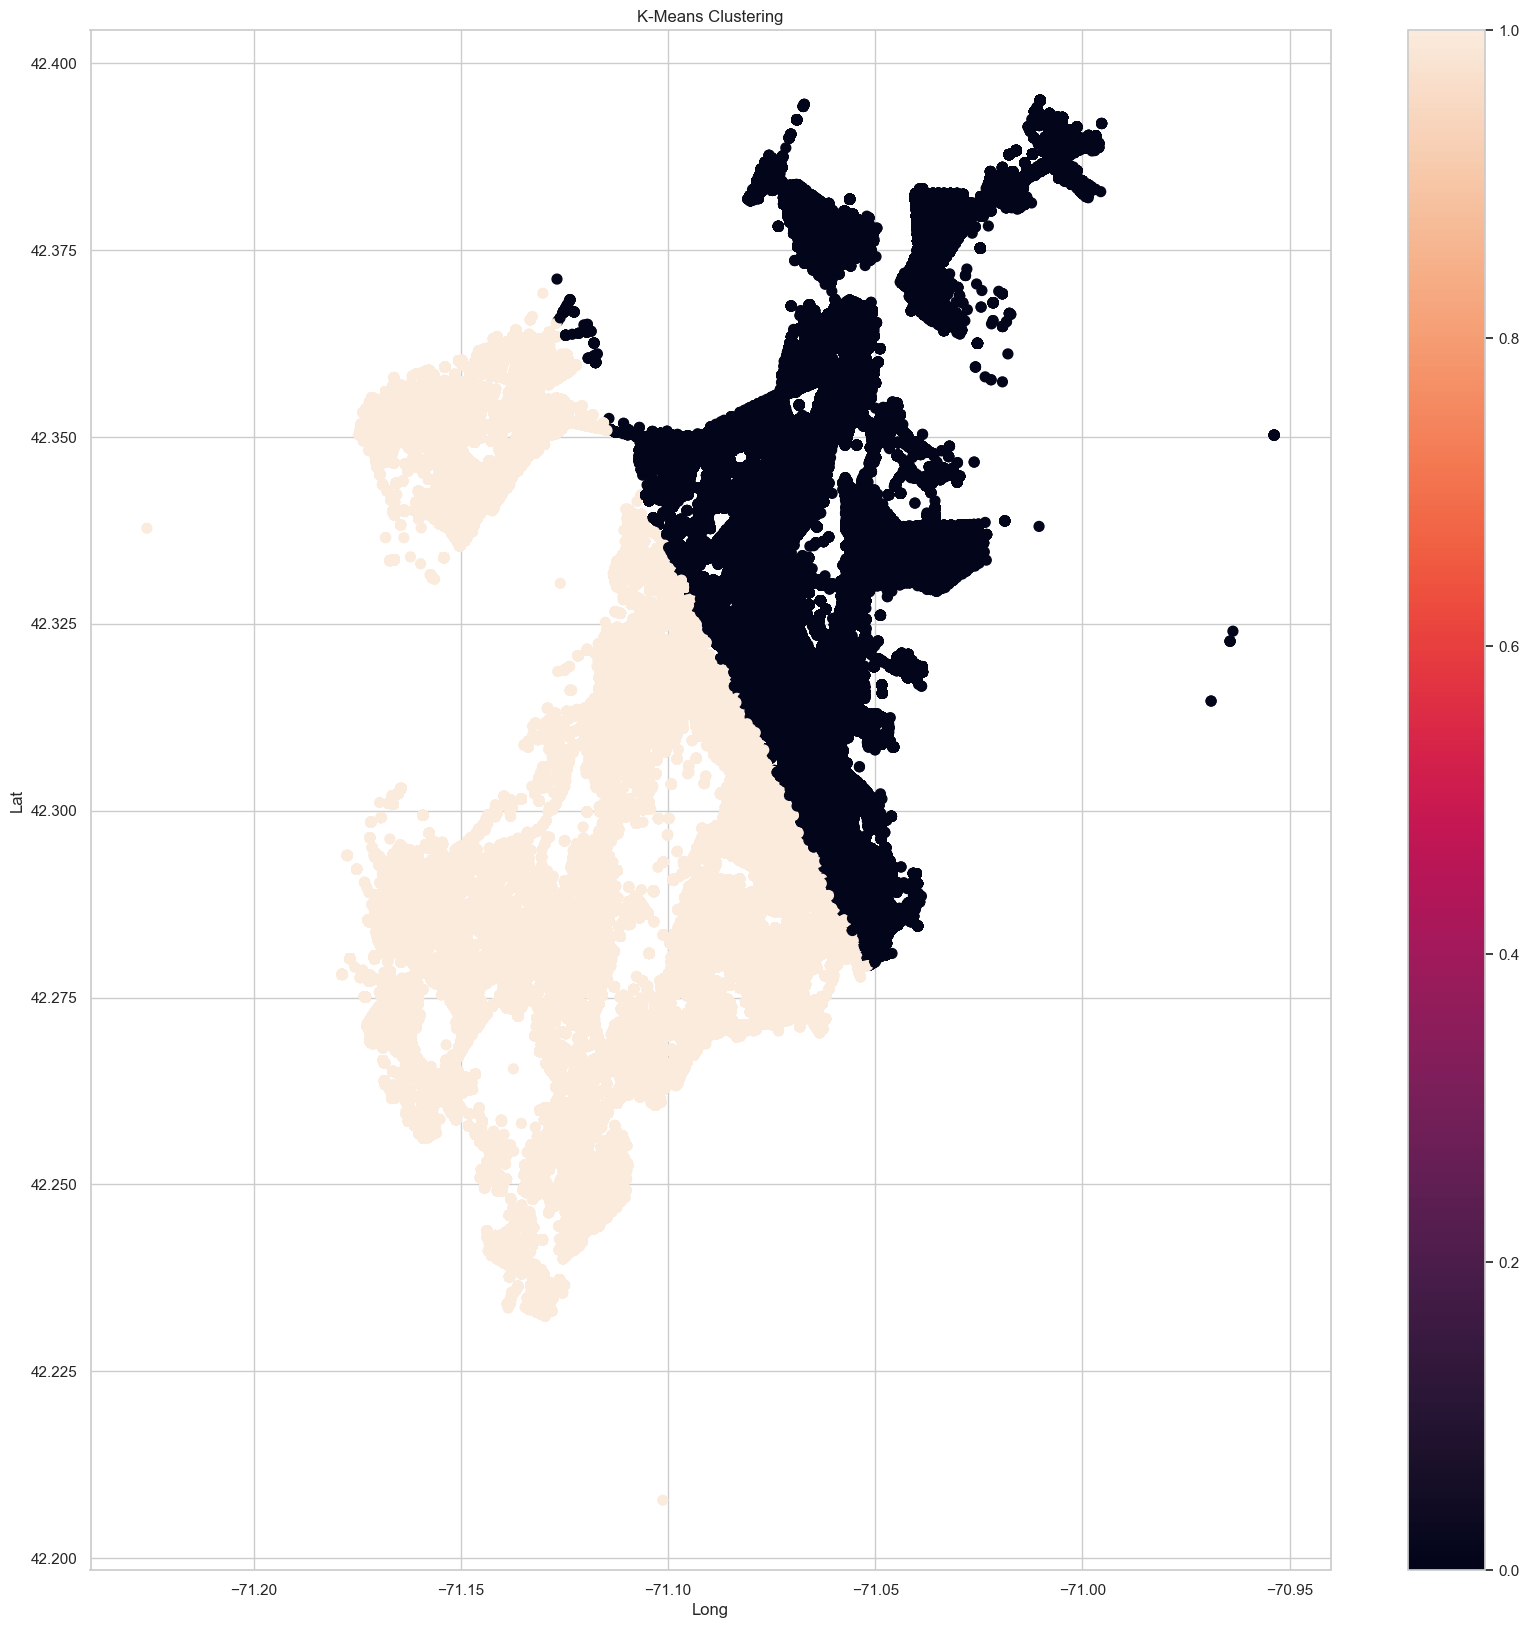

In [94]:
#Plot the clusters obtained using k means#Plot the 
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
scatter = ax.scatter(X['Long'],X['Lat'],
                     c=kmeans[0],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('Long')
ax.set_ylabel('Lat')
plt.colorbar(scatter)

In [95]:
X = location
X = X[~np.isnan(X)]

clust_labels, cent = doKmeans(X, 3)
kmeans = pd.DataFrame(clust_labels)
X.insert((X.shape[1]),'kmeans',kmeans)


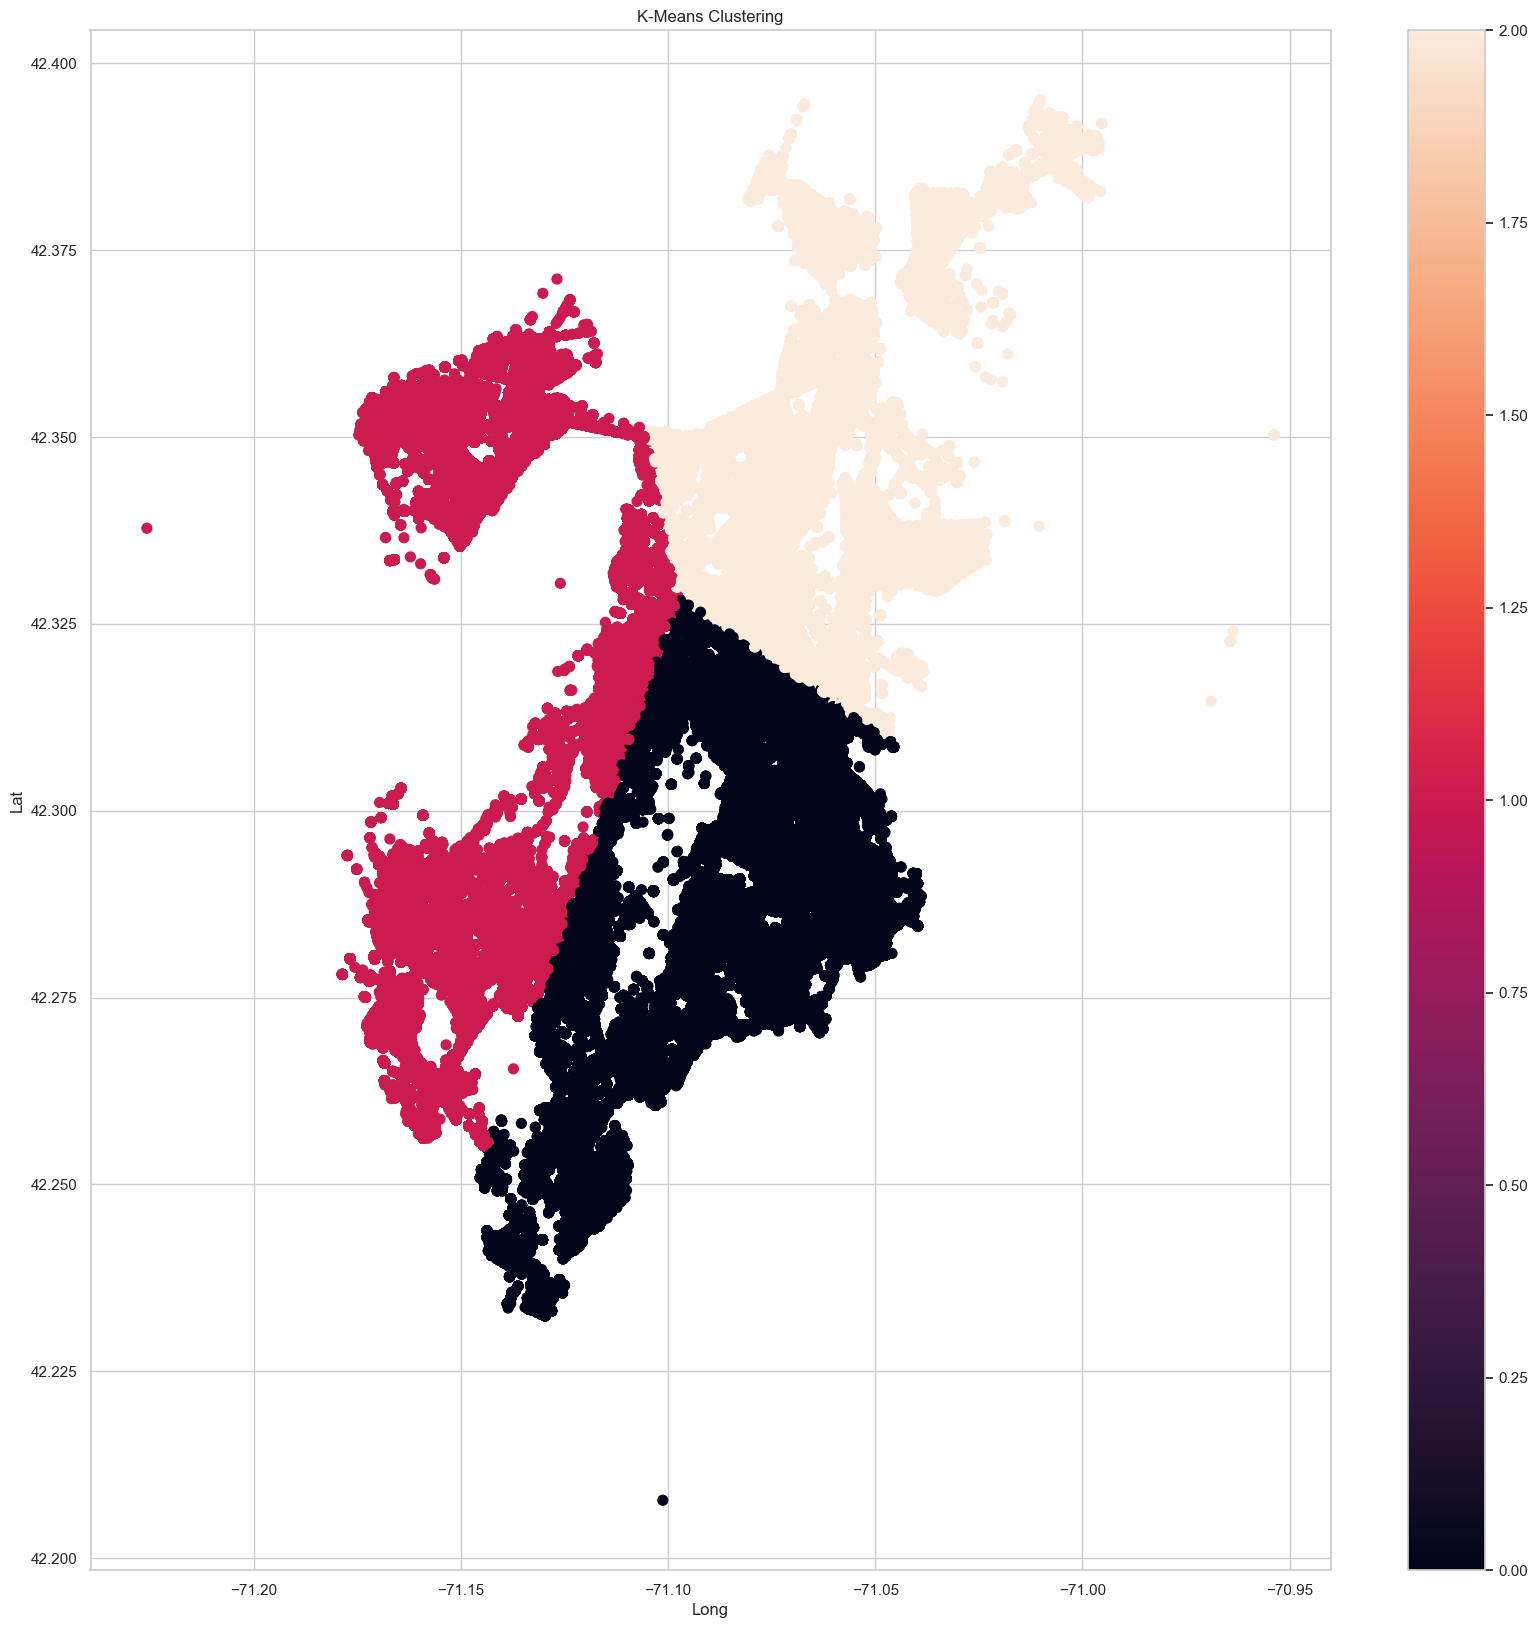

In [96]:
#Plot the clusters obtained using k means#Plot the 
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
scatter = ax.scatter(X['Long'],X['Lat'],
                     c=kmeans[0],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('Long')
ax.set_ylabel('Lat')
plt.colorbar(scatter)


In [97]:
X = location
X = X[~np.isnan(X)]

clust_labels, cent = doKmeans(X, 5)
kmeans = pd.DataFrame(clust_labels)
X.insert((X.shape[1]),'kmeans',kmeans)

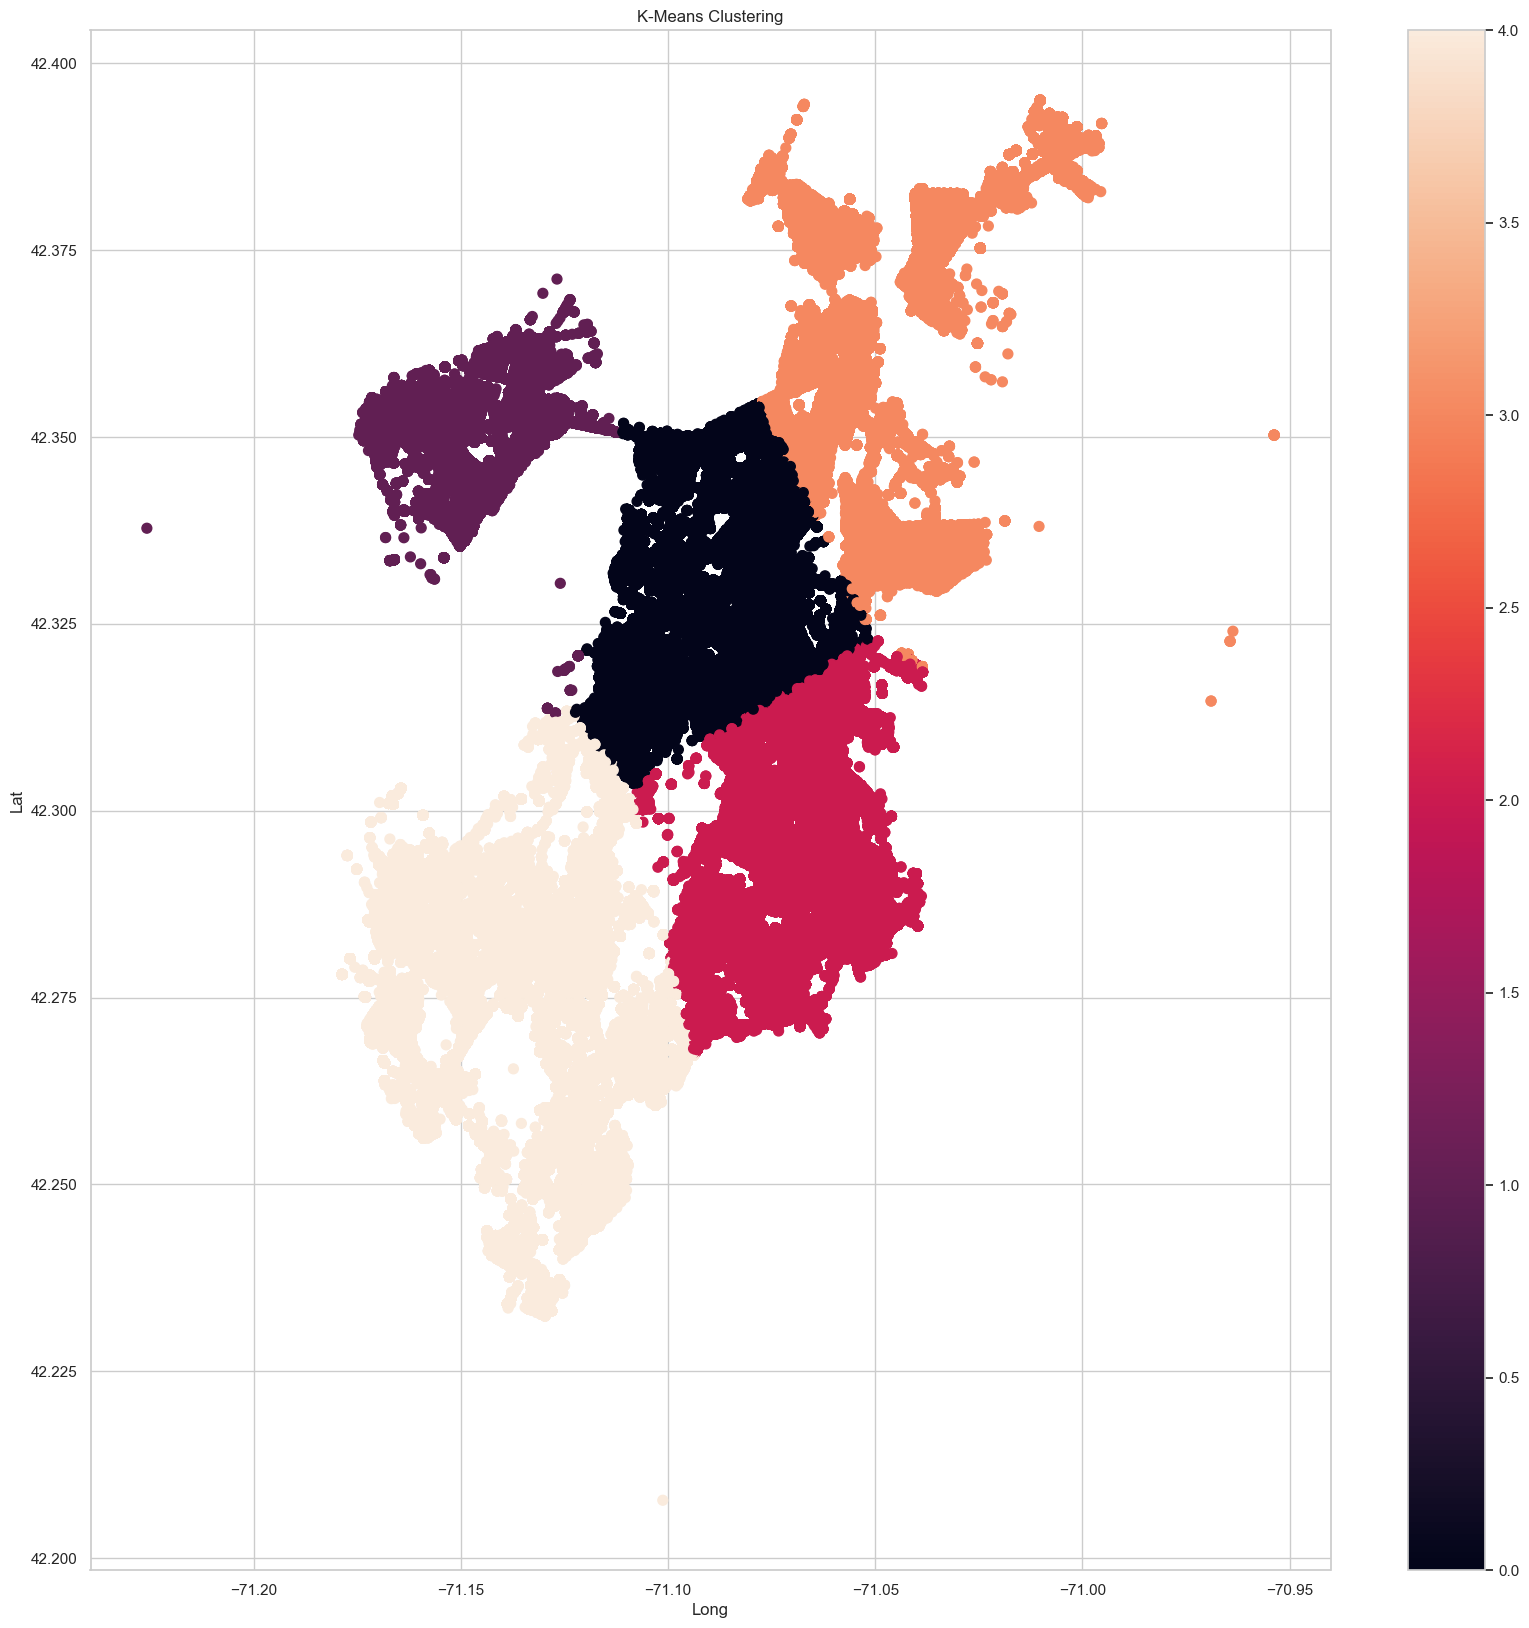

In [98]:
#Plot the clusters obtained using k means#Plot the 
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
scatter = ax.scatter(X['Long'],X['Lat'],
                     c=kmeans[0],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('Long')
ax.set_ylabel('Lat')
plt.colorbar(scatter)

In [99]:
X = location
X = X[~np.isnan(X)]

clust_labels, cent = doKmeans(X, 10)
kmeans = pd.DataFrame(clust_labels)
X.insert((X.shape[1]),'kmeans',kmeans)

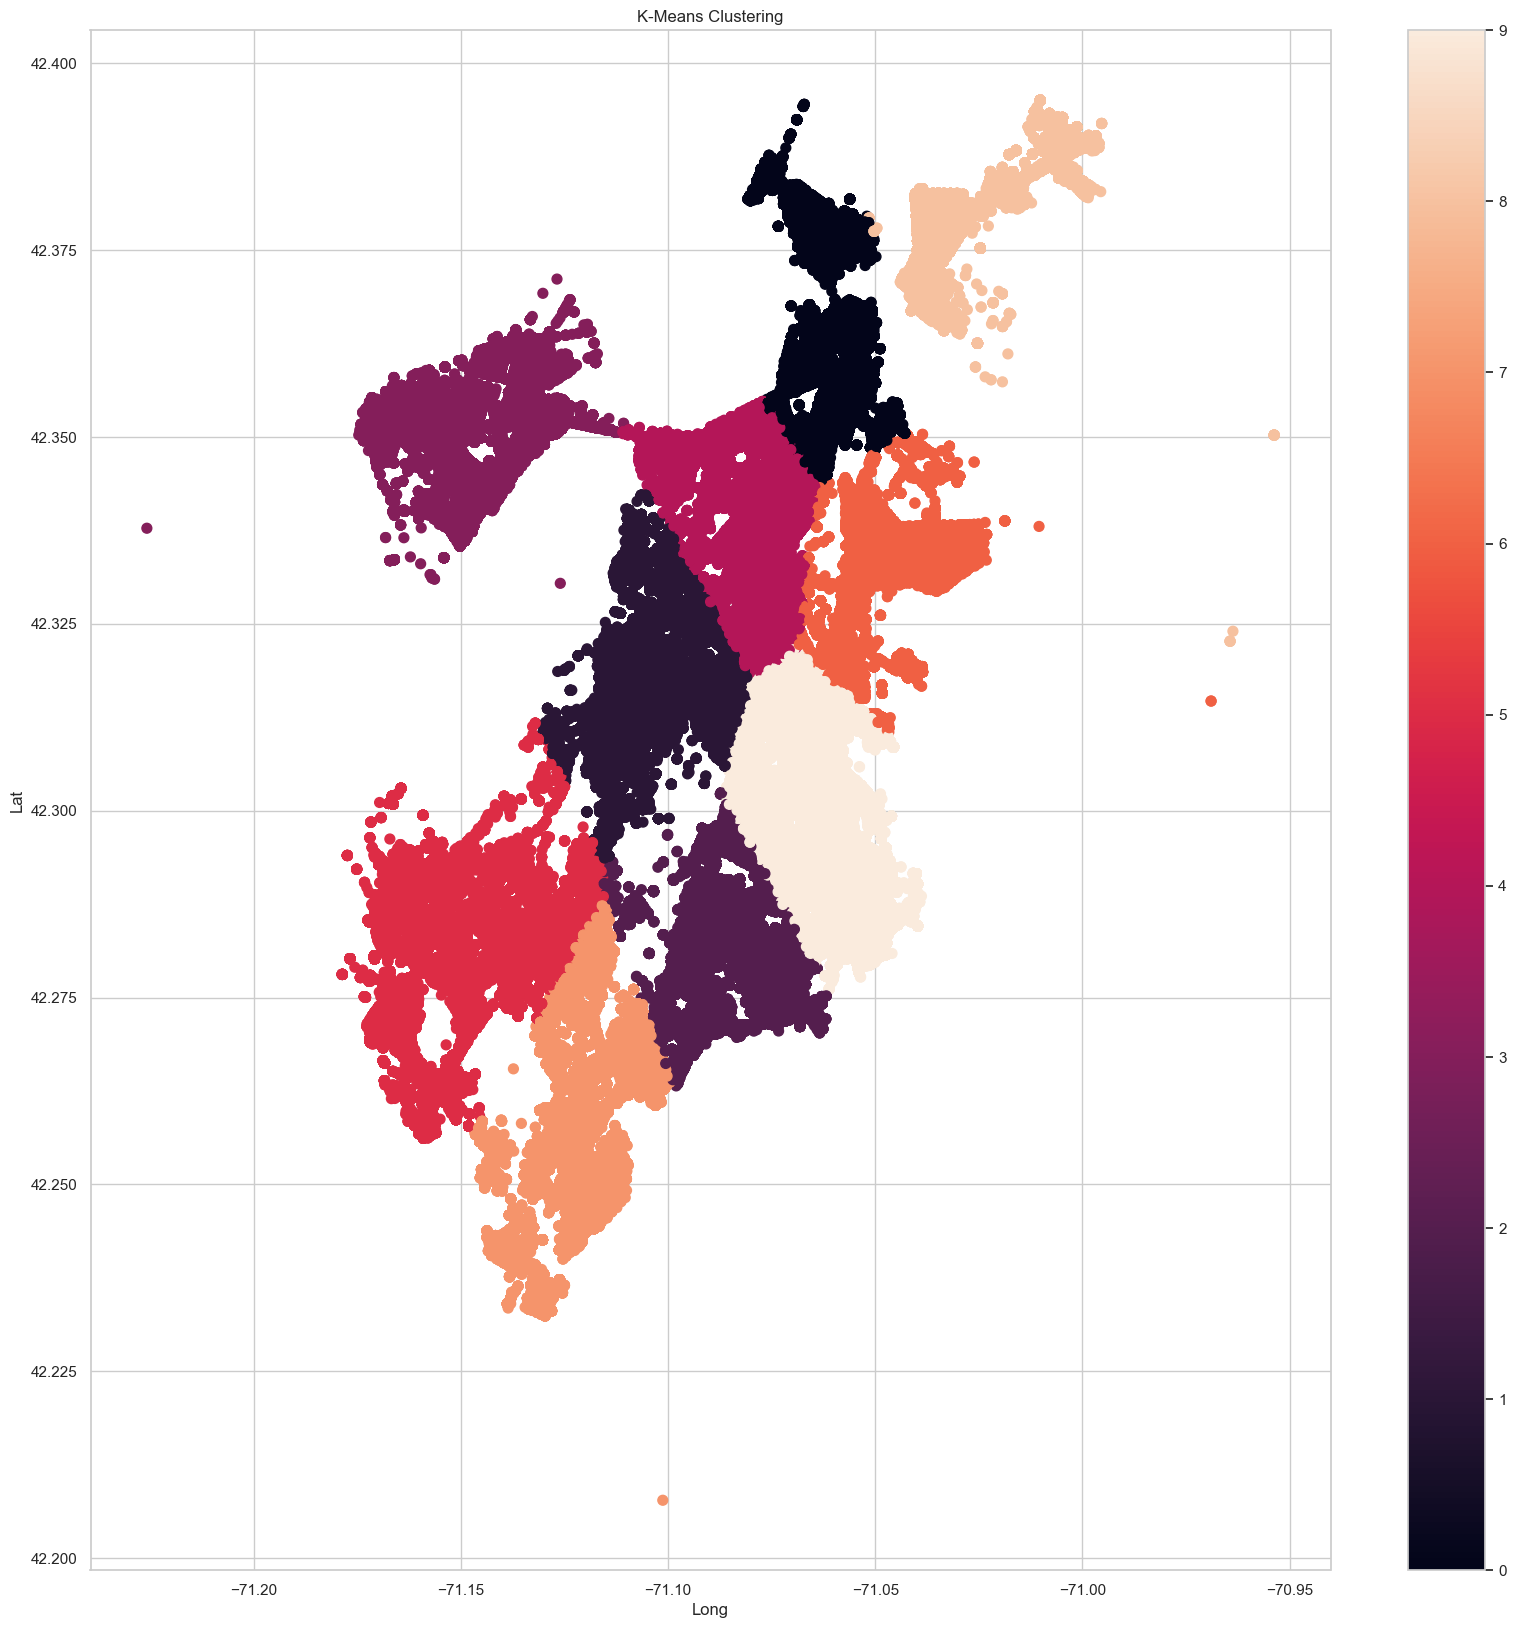

In [100]:
#Plot the clusters obtained using k means#Plot the 
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
scatter = ax.scatter(X['Long'],X['Lat'],
                     c=kmeans[0],s=50)
ax.set_title('K-Means Clustering')
ax.set_xlabel('Long')
ax.set_ylabel('Lat')
plt.colorbar(scatter)


### Clustering with location and OFFENSE_CODE

In [101]:
df_clus = df_pandas[['OFFENSE_CODE','Long','Lat']]
df_clus = df_clus.loc[(df_clus['Lat'] > 40) & (df_clus['Long'] < -60)]
df_clus = df_clus.dropna()
df_clus.describe()

,Long,Lat
count,581152.000000,581152.000000
mean,-71.083642,42.322306
std,0.030789,0.032295
min,-71.225840,42.207760
25%,-71.098700,42.297555
50%,-71.077826,42.326655
75%,-71.061776,42.348624
max,-70.953726,42.395042


In [102]:
X = df_clus.dropna()

clust_labels, cent = doKmeans(X, 2)
kmeans = pd.DataFrame(clust_labels)
X.insert((X.shape[1]),'kmeans',kmeans)

#Plot the clusters obtained using k means#Plot the 
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
scatter = ax.scatter(X['Long'],X['Lat'],
                     c=kmeans[0],s=5)
ax.set_title('K-Means Clustering')
ax.set_xlabel('Long')
ax.set_ylabel('Lat')
plt.colorbar(scatter)
plt.show()


### Clustering with location and month

In [103]:
df_clus = df_pandas[['MONTH','Long','Lat']]
df_clus = df_clus.loc[(df_clus['Lat'] > 40) & (df_clus['Long'] < -60)]
df_clus = df_clus.dropna()

In [104]:
X = df_clus.dropna()

clust_labels, cent = doKmeans(X, 2)
kmeans = pd.DataFrame(clust_labels)
X.insert((X.shape[1]),'kmeans',kmeans)

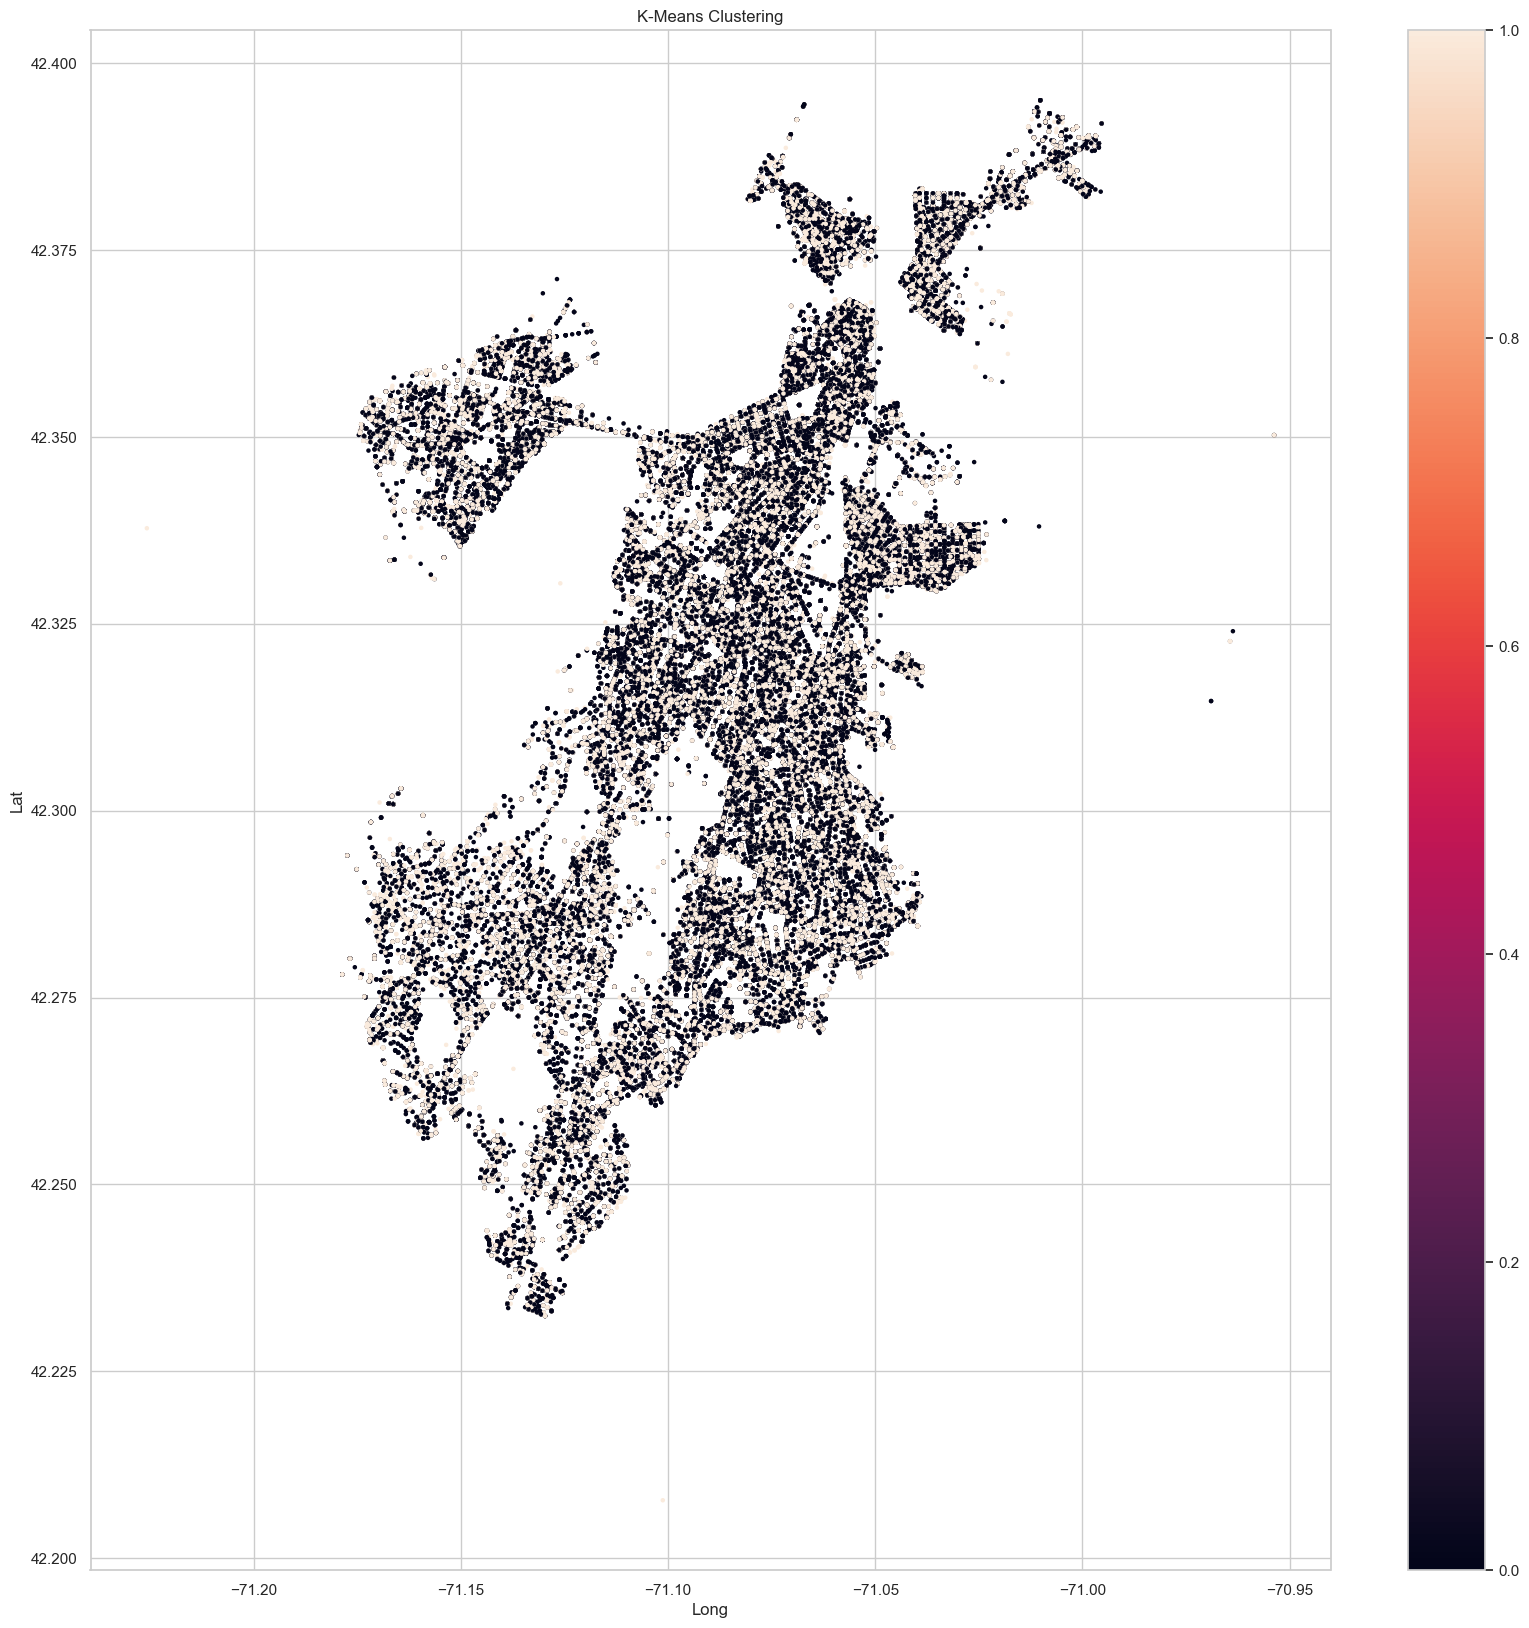

In [105]:
#Plot the clusters obtained using k means#Plot the 
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
scatter = ax.scatter(X['Long'],X['Lat'],
                     c=kmeans[0],s=5)
ax.set_title('K-Means Clustering')
ax.set_xlabel('Long')
ax.set_ylabel('Lat')
plt.colorbar(scatter)